---
In this notebook, we will perform below steps
- Load transformed training data and testing data
- Build multiple ML model using training data
- Hyper-parameter tuning best model to identify best parameters which give best results 
- Evaluate model performance on various metrics and charts 
- Saving the final (best) ML model in S3 which will be used to make inference on new data 
- Interpreting Model using SHAP values

In [1]:
!pip install --upgrade pip --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [2]:
!pip install --upgrade pandas --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [3]:
!pip install --upgrade numpy --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [4]:
!pip install imbalanced-learn --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple --trusted-host=artifactory.alight.com

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/19/79/e86c8fd859dca4fb1fbfc61376afc63210177a235a7bfbe7219b02edf8f3/imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/61/cf/6e354304bcb9c6413c4e02a747b600061c21d38ba51e7e544ac7bc66aecc/threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/91/d4/3b4c8e5a30604df4c7518c562d4bf0502f2fa29221459226e140cf846512/joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/83/92/a4d1f42b29e9f62f9c3fad68d28282a9610a02801e1d89945702f981dd8e/imbalanced_learn-0.9.0-py3

In [5]:
!pip install xgboost --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/a6/32/cd71fbcebde0809c4e911c9f5f65833c2a4bb43defc63d0b9377f3800bda/xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)


In [6]:
!pip install lightgbm --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/19/b7/a880bb0922df5413909d1d6d7831b1e93622f113c7889f58a775a9c79ce4/lightgbm-3.3.3-py3-none-manylinux1_x86_64.whl (2.0 MB)


In [7]:
!pip install bayesian-optimization --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/f6/72/688e132136c70d7a275aae3492608d778efc6f307cb5768fc059d511ff68/bayesian_optimization-1.3.1-py3-none-any.whl (16 kB)


In [8]:
!pip install category_encoders --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple --trusted-host=artifactory.alight.com

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/4a/0d/e825642ae6f15a70bee5d0481ce3861f00dee0e93f1b6eca98a03a109d1d/category_encoders-2.5.1.post0-py2.py3-none-any.whl (72 kB)


In [9]:
conda install shap

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.10.11 |       h06a4308_0         124 KB  /
    certifi-2022.9.24          |   py37h06a4308_0         154 KB  /
    conda-22.9.0               |   py37h89c1867_1         960 KB  /
    openssl-1.1.1s             |       h7f8727e_0         3.6 MB  /
    shap-0.39.0                |   py37h51133e4_0         502 KB  /
    slicer-0.0.7               |     pyhd3eb1b0_0          18 KB  /
    ------------------------------------------------------------
                                           Total:         5.3 MB

The

In [10]:
#importing librarires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import boto3
import io
import time
import gc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score,\
roc_auc_score, make_scorer, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix, average_precision_score,\
ConfusionMatrixDisplay

from sklearn.feature_selection import SelectFromModel
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

import tempfile
import boto3
import joblib

import shap

%matplotlib inline
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

<font color='red'>
We need to edit below cell before running the whole script.
    
If not editted, data will be pulled and stored from S3 bucket as per given values.
</font>

In [11]:
# Mention all file names as string in the below list which are available at "raw_data_path" directory
data_path = f'external/artichauhan/LOA/loa_script/Data'

train_data_path = f'{data_path}/train_data'

train_fnames = ['transformed_train_data.csv']

test_data_path = f'{data_path}/test_data'

test_fnames = ['transformed_test_data.csv']

label = ['y_test.csv']

# Mention the bucket name where pre-processed data will be stored. Usually there will no change in bucket name
bucket='adl-core-sagemaker-studio'

In [12]:
def load_data_from_s3(bucket,raw_data_path,raw_data_fnames):
    s3 = boto3.client('s3')
    dataset_nrows = []
    for i, fname in enumerate(raw_data_fnames):
        if i==0:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data = pd.read_csv(io.BytesIO(obj['Body'].read()))
            dataset_nrows.append(data.shape[0])
            print(f'\tFile read successfully | Shape: {data.shape}')
        else:
            print(f'Reading file: {fname}')
            key = f'{raw_data_path}/{fname}'
            obj = s3.get_object(Bucket=bucket, Key=key)
            data2 = pd.read_csv(io.BytesIO(obj['Body'].read()))
            data = data.append(data2,ignore_index=True)
            dataset_nrows.append(data2.shape[0])
            print(f'\tFile read successfully | Shape: {data2.shape}')

    if sum(dataset_nrows) == data.shape[0]:
        print(f'Data from all files loaded successfully | Final Shape: {data.shape}')
        return data.copy()
    else:
        print('There is discrepency in numbers')
        print(f'\tTotal number of rows combined in all files: {sum(dataset_nrows)}')
        print(f'\tAfter combining all files total number of rows are: {data.shape[0]}')
        return None

#### Loading train set

In [13]:
train_set = load_data_from_s3(bucket,train_data_path, train_fnames)

Reading file: transformed_train_data.csv
	File read successfully | Shape: (1032453, 12)
Data from all files loaded successfully | Final Shape: (1032453, 12)


#### Loading test set

In [14]:
test_set = load_data_from_s3(bucket,test_data_path, test_fnames)

Reading file: transformed_test_data.csv
	File read successfully | Shape: (258114, 11)
Data from all files loaded successfully | Final Shape: (258114, 11)


#### Loading test label column

In [15]:
y_test = load_data_from_s3(bucket,test_data_path, label)

Reading file: y_test.csv
	File read successfully | Shape: (258114, 1)
Data from all files loaded successfully | Final Shape: (258114, 1)


In [16]:
# #checking distribution of target feature
# sns.countplot(data=y_test, x='mapped_employment_status_code_label')
# plt.savefig('Test label - XGBoost.png')
# plt.show()

#### Separating target label from train data

In [17]:
# Dropping client and person internal id
train_set.drop(columns=['person_internal_id','client_id'],axis=1,inplace=True)

In [18]:
train_set['mapped_employment_status_code_label'].value_counts(normalize=True)

0    0.770616
1    0.229384
Name: mapped_employment_status_code_label, dtype: float64

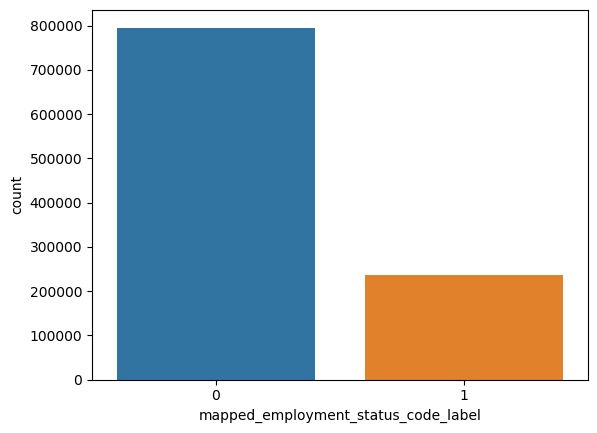

In [19]:
#checking distribution of target feature
sns.countplot(data=train_set, x='mapped_employment_status_code_label')
plt.show()

#### Undersampling the majority class of target column 

In [20]:
# # Separating classes
# LOA = train_set[train_set.mapped_employment_status_code_label == 1]
# Active = train_set[train_set.mapped_employment_status_code_label == 0]

In [21]:
# print(LOA.shape)
# print(Active.shape)

In [22]:
# # Undersampling the majority class
# # Import the resampling package
# from sklearn.utils import resample
# undersample = resample(Active, 
#                        replace=True, 
#                        n_samples=len(LOA), #set the number of samples to equal the number of the minority class
#                        random_state=42)

# # Returning to new training set
# undersample_train = pd.concat([LOA, undersample])

In [23]:
# undersample_train.shape

In [24]:
# undersample_train.columns

In [25]:
# undersample_train.mapped_employment_status_code_label.value_counts()

In [26]:
# train_set = undersample_train

In [27]:
# print(f'Uploading pre-processed data here -> s3://{bucket}/{prefix}')

# undersample_train.to_csv(f's3://{bucket}/{prefix}/train_set', index=False)

#### Separating out dependent and independent variables from the train data:

In [28]:
X_train = train_set.drop(columns=['mapped_employment_status_code_label'], axis=1)
y_train = train_set['mapped_employment_status_code_label']

In [29]:
print(X_train.shape)
print(y_train.shape)

(1032453, 9)
(1032453,)


#### Hot encoding the categorical variables in training dataset:

In [30]:
import category_encoders as ce

In [31]:
cat_col = X_train.select_dtypes(include=['object']).columns

In [32]:
print(cat_col)

Index(['gender', 'marital_status', 'is_union', 'platform_indicator_code',
       'mapped_fullpart_code', 'mapped_hourly_salary_code', 'is_rehire',
       'base_pay_regular_expected_annual_salary_range'],
      dtype='object')


In [33]:
encoder = ce.OneHotEncoder(cols=cat_col, drop_invariant = True, use_cat_names=True)

In [34]:
X_train = encoder.fit_transform(X_train)

In [35]:
#Hot encoded data
X_train.head(2)

age  gender_male  gender_female  gender_unknown  marital_status_unknown  \
0   62            1              0               0                       1   
1   33            1              0               0                       0   

   marital_status_Married  marital_status_Single  marital_status_Divorced  \
0                       0                      0                        0   
1                       1                      0                        0   

   is_union_N  is_union_Y  platform_indicator_code_HM  \
0           1           0                           1   
1           1           0                           0   

   platform_indicator_code_R4  platform_indicator_code_unknown  \
0                           0                                0   
1                           1                                0   

   platform_indicator_code_DBE  platform_indicator_code_DCE  \
0                            0                            0   
1                            0                            0   

   platform_indicator_code_R3  platform_indicator_code_HWE4  \
0                           0                             0   
1                           0                             0   

   mapped_fullpart_code_FLTM  mapped_fullpart_code_unknown  \
0                          1                             0   
1                          1                             0   

   mapped_fullpart_code_PRTM  mapped_hourly_salary_code_HRLY  \
0                          0                               1   
1                          0                               1   

   mapped_hourly_salary_code_unknown  mapped_hourly_salary_code_SLRY  \
0                                  0                               0   
1                                  0                               0   

   is_rehire_Y  is_rehire_N  \
0            1            0   
1            1            0   

   base_pay_regular_expected_annual_salary_range_40,000 - 59,999  \
0                                                  1               
1                                                  0               

   base_pay_regular_expected_annual_salary_range_60,000 - 79,999  \
0                                                  0               
1                                                  1               

   base_pay_regular_expected_annual_salary_range_20,000 - 39,999  \
0                                                  0               
1                                                  0               

   base_pay_regular_expected_annual_salary_range_<20,000  \
0                                                  0       
1                                                  0       

   base_pay_regular_expected_annual_salary_range_80,000 - 99,999  \
0                                                  0               
1                                                  0               

   base_pay_regular_expected_annual_salary_range_100,000-174999  \
0                                                  0              
1                                                  0              

   base_pay_regular_expected_annual_salary_range_175000-249999  \
0                                                  0             
1                                                  0             

   base_pay_regular_expected_annual_salary_range_>250000  
0                                                  0      
1                                                  0

In [36]:
X_train.shape

(1032453, 33)

In [37]:
X_train.columns

Index(['age', 'gender_male', 'gender_female', 'gender_unknown',
       'marital_status_unknown', 'marital_status_Married',
       'marital_status_Single', 'marital_status_Divorced', 'is_union_N',
       'is_union_Y', 'platform_indicator_code_HM',
       'platform_indicator_code_R4', 'platform_indicator_code_unknown',
       'platform_indicator_code_DBE', 'platform_indicator_code_DCE',
       'platform_indicator_code_R3', 'platform_indicator_code_HWE4',
       'mapped_fullpart_code_FLTM', 'mapped_fullpart_code_unknown',
       'mapped_fullpart_code_PRTM', 'mapped_hourly_salary_code_HRLY',
       'mapped_hourly_salary_code_unknown', 'mapped_hourly_salary_code_SLRY',
       'is_rehire_Y', 'is_rehire_N',
       'base_pay_regular_expected_annual_salary_range_40,000 - 59,999',
       'base_pay_regular_expected_annual_salary_range_60,000 - 79,999',
       'base_pay_regular_expected_annual_salary_range_20,000 - 39,999',
       'base_pay_regular_expected_annual_salary_range_<20,000',
       'ba

#### SMOTE for oversampling train set

In [38]:
import imblearn
from imblearn.over_sampling import SMOTE
Smote = SMOTE(random_state=42)
X_res, y_res = Smote.fit_resample(X_train, y_train)

In [39]:
print('X_train: ',X_res.shape)
print('y_train: ',y_res.shape)

X_train:  (1591250, 33)
y_train:  (1591250,)


In [40]:
X_train = X_res
y_train = y_res

In [41]:
y_train.value_counts()

0    795625
1    795625
Name: mapped_employment_status_code_label, dtype: int64

#### Hot encoding the test data:

In [42]:
test_set.columns

Index(['person_internal_id', 'client_id', 'age', 'gender', 'marital_status',
       'is_union', 'platform_indicator_code', 'mapped_fullpart_code',
       'mapped_hourly_salary_code', 'is_rehire',
       'base_pay_regular_expected_annual_salary_range'],
      dtype='object')

In [43]:
X_test = test_set.drop(columns=['person_internal_id','client_id'],axis=1)

In [44]:
X_test = encoder.transform(X_test)

In [45]:
print('X_test: ',X_test.shape)
print('y_test: ',y_test.shape)

X_test:  (258114, 33)
y_test:  (258114, 1)


In [46]:
y_test.value_counts()

mapped_employment_status_code_label
0                                      198907
1                                       59207
dtype: int64

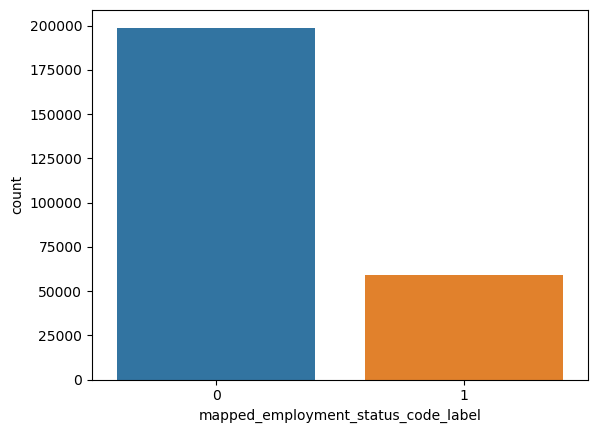

In [47]:
#checking distribution of target feature
sns.countplot(data=y_test, x='mapped_employment_status_code_label')
plt.show()

In [48]:
# X_test

In [49]:
y_test = y_test['mapped_employment_status_code_label']

In [50]:
# y_test

## Training ML Models (with default parameters)

### LogisticRegression

In [51]:
%%time
lr = LogisticRegression()

lr = lr.fit(X_train, y_train)

CPU times: user 2min 4s, sys: 2min 6s, total: 4min 10s
Wall time: 19.6 s


In [52]:
pred_train_lr = lr.predict(X_train)

In [53]:
pred_lr  = lr.predict(X_test)

### RandomForestClassifier

In [54]:
%%time
rf = RandomForestClassifier()

rf = rf.fit(X_train, y_train)

CPU times: user 2min 49s, sys: 668 ms, total: 2min 49s
Wall time: 2min 49s


In [55]:
pred_train_rf  = rf.predict(X_train)

In [56]:
pred_rf  = rf.predict(X_test)

### SVC

In [57]:
# svc = SVC()

# svc = svc.fit(X_train, y_train)

In [58]:
# pred_train_svc  = svc.predict(X_train)

In [59]:
# pred_svc  = svc.predict(X_test)

### DecisionTreeClassifier

In [60]:
%%time
dt = DecisionTreeClassifier()

dt = dt.fit(X_train, y_train)

CPU times: user 7.56 s, sys: 968 µs, total: 7.57 s
Wall time: 7.56 s


In [61]:
pred_train_dt  = dt.predict(X_train)

In [62]:
pred_dt  = dt.predict(X_test)

### GaussianNB

In [63]:
%%time
gnb = GaussianNB()

gnb = gnb.fit(X_train, y_train)

CPU times: user 916 ms, sys: 104 ms, total: 1.02 s
Wall time: 1.02 s


In [64]:
pred_train_gnb  = gnb.predict(X_train)

In [65]:
pred_gnb  = gnb.predict(X_test)

### XGBClassifier

In [66]:
%%time
xgb = XGBClassifier()

xgb = xgb.fit(X_train.values, y_train.values)

CPU times: user 8min 31s, sys: 7.97 s, total: 8min 39s
Wall time: 33.4 s


In [67]:
pred_train_xgb  = xgb.predict(X_train)

In [68]:
pred_xgb  = xgb.predict(X_test)

### LGBMClassifier

In [69]:
%%time
lgbm = LGBMClassifier()

lgbm = lgbm.fit(X_train.values, y_train.values)

CPU times: user 32.4 s, sys: 537 ms, total: 33 s
Wall time: 2.34 s


In [70]:
pred_train_lgbm  = lgbm.predict(X_train)

In [71]:
pred_lgbm  = lgbm.predict(X_test)

### KNeighborsClassifier

In [72]:
# %%time
# knn = KNeighborsClassifier()
# knn = knn.fit(X_train, y_train)

In [73]:
# pred_train_knn = knn.predict(X_train)

In [74]:
# pred_knn = knn.predict(X_test)

### MLPClassifier

In [75]:
# %%time
# mlpc = MLPClassifier()
# mlpc.fit(X_train, y_train)

In [76]:
# pred_train_mlpc = mlpc.predict(X_train)

In [77]:
# pred_mlpc = mlpc.predict(X_test)

## Classification Reports of above models on Test Set

In [78]:
 print("Logistic Regression:\n", classification_report(y_train, pred_train_lr))
print("ROC AUC score for data: ", roc_auc_score(y_train, lr.predict_proba(X_train)[:,1], average='weighted'))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.64      0.65      0.64    795625
           1       0.64      0.63      0.63    795625

    accuracy                           0.64   1591250
   macro avg       0.64      0.64      0.64   1591250
weighted avg       0.64      0.64      0.64   1591250

ROC AUC score for data:  0.690019020832827


In [79]:
print("RandonForestClassifier:\n", classification_report(y_train, pred_train_rf))
print("ROC AUC score for data: ", roc_auc_score(y_train, rf.predict_proba(X_train)[:,1], average='weighted'))

RandonForestClassifier:
               precision    recall  f1-score   support

           0       0.77      0.70      0.73    795625
           1       0.73      0.79      0.76    795625

    accuracy                           0.75   1591250
   macro avg       0.75      0.75      0.75   1591250
weighted avg       0.75      0.75      0.75   1591250

ROC AUC score for data:  0.838959696955056


In [80]:
print("DecisionTreeClassifier:\n", classification_report(y_train, pred_train_dt))
print("ROC AUC score for data: ", roc_auc_score(y_train, dt.predict_proba(X_train)[:,1], average='weighted'))

DecisionTreeClassifier:
               precision    recall  f1-score   support

           0       0.77      0.71      0.74    795625
           1       0.73      0.78      0.76    795625

    accuracy                           0.75   1591250
   macro avg       0.75      0.75      0.75   1591250
weighted avg       0.75      0.75      0.75   1591250

ROC AUC score for data:  0.8395220756433979


In [81]:
print("GaussianNB:\n", classification_report(y_train, pred_train_gnb))
print("ROC AUC score for data: ", roc_auc_score(y_train, gnb.predict_proba(X_train)[:,1], average='weighted'))

GaussianNB:
               precision    recall  f1-score   support

           0       0.67      0.25      0.37    795625
           1       0.54      0.88      0.67    795625

    accuracy                           0.56   1591250
   macro avg       0.60      0.56      0.52   1591250
weighted avg       0.60      0.56      0.52   1591250

ROC AUC score for data:  0.6554251289082023


In [82]:
print("XGBClassifier:\n", classification_report(y_train, pred_train_xgb))
print("ROC AUC score for data: ", roc_auc_score(y_train, xgb.predict_proba(X_train)[:,1], average='weighted'))

XGBClassifier:
               precision    recall  f1-score   support

           0       0.74      0.68      0.71    795625
           1       0.70      0.76      0.73    795625

    accuracy                           0.72   1591250
   macro avg       0.72      0.72      0.72   1591250
weighted avg       0.72      0.72      0.72   1591250

ROC AUC score for data:  0.804016019848136


In [83]:
print("LGBMClassifier:\n", classification_report(y_train, pred_train_lgbm))
print("ROC AUC score for data: ", roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1], average='weighted'))

LGBMClassifier:
               precision    recall  f1-score   support

           0       0.72      0.67      0.70    795625
           1       0.69      0.75      0.72    795625

    accuracy                           0.71   1591250
   macro avg       0.71      0.71      0.71   1591250
weighted avg       0.71      0.71      0.71   1591250

ROC AUC score for data:  0.7905375754181998


In [84]:
# print("KNeighborsClassifier:\n", classification_report(y_train, pred_train_knn))
# print("ROC AUC score for data: ", roc_auc_score(y_train, knn.predict_proba(X_train)[:,1], average='weighted'))

In [85]:
# print("MLPClassifier:\n", classification_report(y_train, pred_train_mlpc))
# print("ROC AUC score for data: ", roc_auc_score(y_train, mlpc.predict_proba(X_train)[:,1], average='weighted'))

## Classification Reports of above models on Test Set

In [86]:
print("Logistic Regression:\n", classification_report(y_test, pred_lr))
print("ROC AUC score for data: ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1], average='weighted'))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.85      0.65      0.74    198907
           1       0.35      0.62      0.44     59207

    accuracy                           0.64    258114
   macro avg       0.60      0.63      0.59    258114
weighted avg       0.74      0.64      0.67    258114

ROC AUC score for data:  0.6828364130244728


In [87]:
print("RandonForestClassifier:\n", classification_report(y_test, pred_rf))
print("ROC AUC score for data: ", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1], average='weighted'))

RandonForestClassifier:
               precision    recall  f1-score   support

           0       0.89      0.69      0.77    198907
           1       0.40      0.70      0.51     59207

    accuracy                           0.69    258114
   macro avg       0.64      0.70      0.64    258114
weighted avg       0.78      0.69      0.71    258114

ROC AUC score for data:  0.7700626140259749


In [88]:
print("DecisionTreeClassifier:\n", classification_report(y_test, pred_dt))
print("ROC AUC score for data: ", roc_auc_score(y_test, dt.predict_proba(X_test)[:,1], average='weighted'))

DecisionTreeClassifier:
               precision    recall  f1-score   support

           0       0.89      0.69      0.78    198907
           1       0.40      0.70      0.51     59207

    accuracy                           0.69    258114
   macro avg       0.64      0.70      0.64    258114
weighted avg       0.77      0.69      0.72    258114

ROC AUC score for data:  0.7646545201064004


In [89]:
print("GaussianNB:\n", classification_report(y_test, pred_gnb))
print("ROC AUC score for data: ", roc_auc_score(y_test, gnb.predict_proba(X_test)[:,1], average='weighted'))

GaussianNB:
               precision    recall  f1-score   support

           0       0.86      0.25      0.39    198907
           1       0.26      0.86      0.39     59207

    accuracy                           0.39    258114
   macro avg       0.56      0.56      0.39    258114
weighted avg       0.72      0.39      0.39    258114

ROC AUC score for data:  0.6488161281566579


In [90]:
print("LGBMClassifier:\n", classification_report(y_test, pred_lgbm))
print("ROC AUC score for data: ", roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1], average='weighted'))

LGBMClassifier:
               precision    recall  f1-score   support

           0       0.89      0.67      0.77    198907
           1       0.40      0.73      0.52     59207

    accuracy                           0.68    258114
   macro avg       0.65      0.70      0.64    258114
weighted avg       0.78      0.68      0.71    258114

ROC AUC score for data:  0.7820524277154652


In [91]:
# print("KNeighborsClassifier:\n", classification_report(y_test, pred_knn))
# print("ROC AUC score for data: ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1], average='weighted'))

In [92]:
# print("MLPClassifier:\n", classification_report(y_test, pred_mlpc))
# print("ROC AUC score for data: ", roc_auc_score(y_test, mlpc.predict_proba(X_test)[:,1], average='weighted'))

In [93]:
print("XGBClassifier:\n", classification_report(y_test, pred_xgb))
print('ROC AUC score=%.2f' %(roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1], average='weighted')))
print('AUPRC=%.2f' %(average_precision_score(y_test, xgb.predict_proba(X_test)[:,1], average='weighted')))

XGBClassifier:
               precision    recall  f1-score   support

           0       0.89      0.68      0.77    198907
           1       0.41      0.73      0.52     59207

    accuracy                           0.69    258114
   macro avg       0.65      0.71      0.65    258114
weighted avg       0.78      0.69      0.72    258114

ROC AUC score=0.79
AUPRC=0.56


In [94]:
metrics_keeper = pd.DataFrame()
classes = 2
class_names = ["No","Yes"]

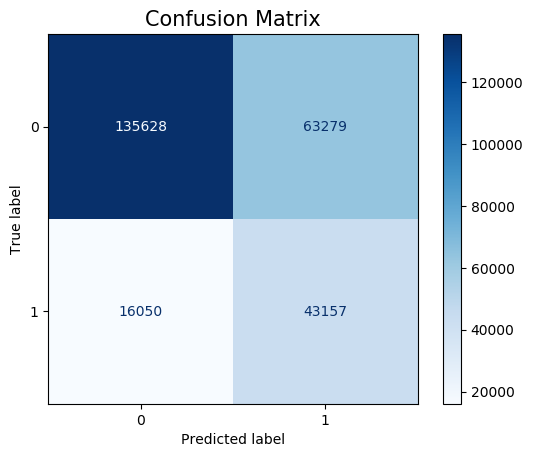

In [224]:
plot_confusion_matrix(estimator=xgb, X=X_test, y_true=y_test, cmap='Blues',values_format='.0f')
plt.title('Confusion Matrix', size=15)
# plt.savefig('Confusion Matrix.png')
plt.show()

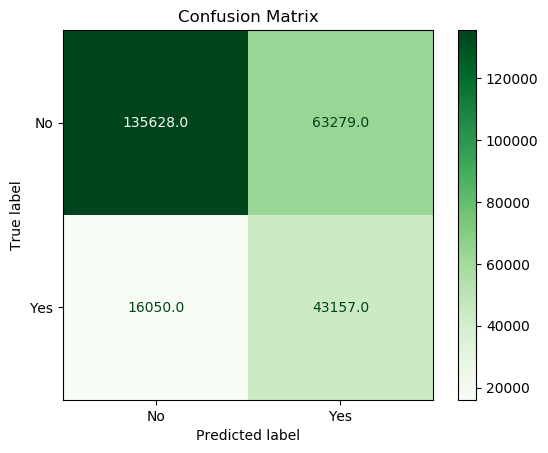

In [95]:
# model_name = "xgb"
# xgb = XGBClassifier()
# xgb = xgb.fit(X.values, train_y.values)
# pred  = xgb.predict(test_X)
# accuracy = accuracy_score(test_y, pred)
# kappa = cohen_kappa_score(test_y, pred)
# roc = roc_auc_score(test_y, pred)
# precision, recall, _ = precision_recall_curve(test_y, pred)
# aucpr = auc(recall, precision)
clr = [i for i in classification_report(y_test, pred_xgb).split(" ") if i !="" and "\n" not in i][:-9]
plot_confusion_matrix(xgb, X_test, y_test, display_labels=class_names, cmap=plt.cm.Greens, values_format = '.1f')  
plt.title("Confusion Matrix")
plt.show()

In [96]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, pred_xgb)
print(cf_matrix)

[[135628  63279]
 [ 16050  43157]]


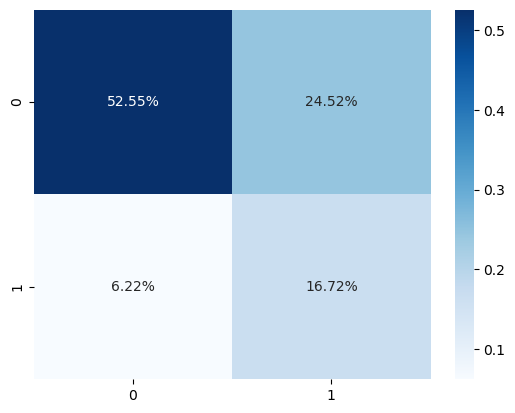

In [97]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [98]:
# # FPR = FP/FP+TN (class 1 FPR)
# FPR = 63279/(63279+135628)
# round(FPR,2)

In [99]:
# FPR = FP/FP+TP (Weighted FPR for class 1 and 0)
FPR = 63279/(43157+63279)
round(FPR,2)

0.59

In [100]:
# # TPR = TP/TP+FN (class 1 TPR)
# TPR = 43157/(43157+16050)
# round(TPR,2)

In [101]:
# TPR = TN/TN+FN (Weighted TPR for class 1 and 0)
TPR = 135628/(135628+16050)
round(TPR,2)

0.89

The below Roc Curve is based on the above calculation of FPR and TPR. Here it is created mannualy based on Rahul's code as asked by Mike. The manual calculation is different then actail calculation due to unbalanced set.

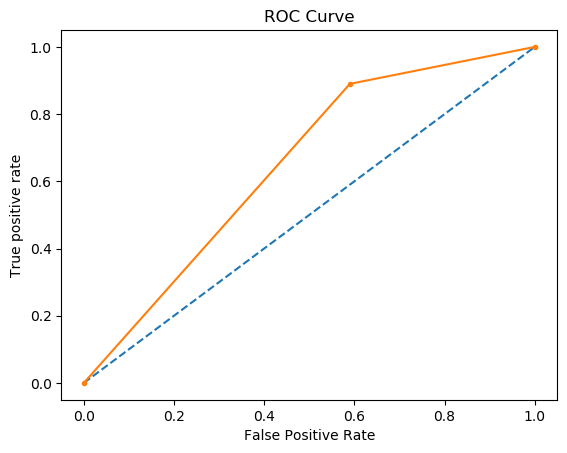

In [102]:
# from sklearn.metrics import roc_auc_score, roc_curve, calculated manually to adjust the plot
# print(roc_curve(y_val,pred))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.plot([0,0.59,1], [0,0.89,1], marker='.')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True positive rate")
plt.show()

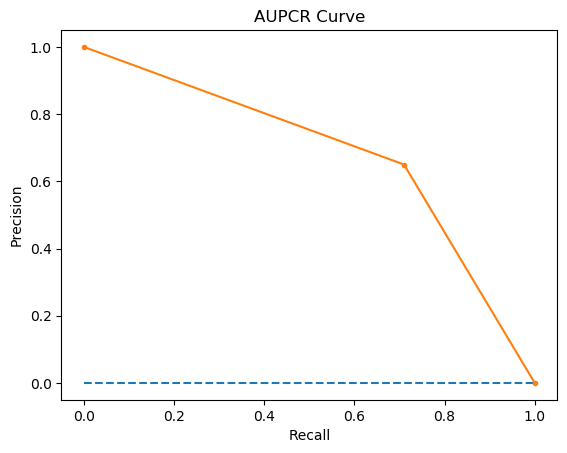

In [103]:
# plotting macro recall and precision
plt.plot([0, 1], [0, 0], linestyle='--', label='No Skill')
plt.plot([1,.71,0], [0,.65,1], marker='.')
plt.title("AUPCR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [104]:
print('Macro Averaged Metrics Score on best XGBoost model on Testing Set')
print('Macro Recall=%.2f' %(recall_score(y_test, pred_xgb, average='macro')))
print('Macro Precision=%.2f' %(precision_score(y_test, pred_xgb, average='macro')))
print('Macro F1 Score=%.2f' %(f1_score(y_test, pred_xgb, average='macro')))
print('Macro ROC AUC=%.2f' %(roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1], average='macro')))
print('Macro AUPRC=%.2f' %(average_precision_score(y_test, xgb.predict_proba(X_test)[:,1], average='macro')))
print('Macro Simple Accuracy=%.2f' %(accuracy_score(y_test, pred_xgb)))

Macro Averaged Metrics Score on best XGBoost model on Testing Set
Macro Recall=0.71
Macro Precision=0.65
Macro F1 Score=0.65
Macro ROC AUC=0.79
Macro AUPRC=0.56
Macro Simple Accuracy=0.69


In [105]:
print('Weighted Average Metrics Score on best XGBoost model on Testing Set')
print('Weighted Recall=%.2f' %(recall_score(y_test, pred_xgb, average='weighted')))
print('Weighted Precision=%.2f' %(precision_score(y_test, pred_xgb, average='weighted')))
print('MaWeightedcro F1 Score=%.2f' %(f1_score(y_test, pred_xgb, average='weighted')))
print('Weighted ROC AUC=%.2f' %(roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1], average='weighted')))
print('Weighted AUPRC=%.2f' %(average_precision_score(y_test, xgb.predict_proba(X_test)[:,1], average='weighted')))
print('Weighted Simple Accuracy=%.2f' %(accuracy_score(y_test, pred_xgb)))

Weighted Average Metrics Score on best XGBoost model on Testing Set
Weighted Recall=0.69
Weighted Precision=0.78
MaWeightedcro F1 Score=0.72
Weighted ROC AUC=0.79
Weighted AUPRC=0.56
Weighted Simple Accuracy=0.69


## Features Importance from XGBoost Model with default parameters

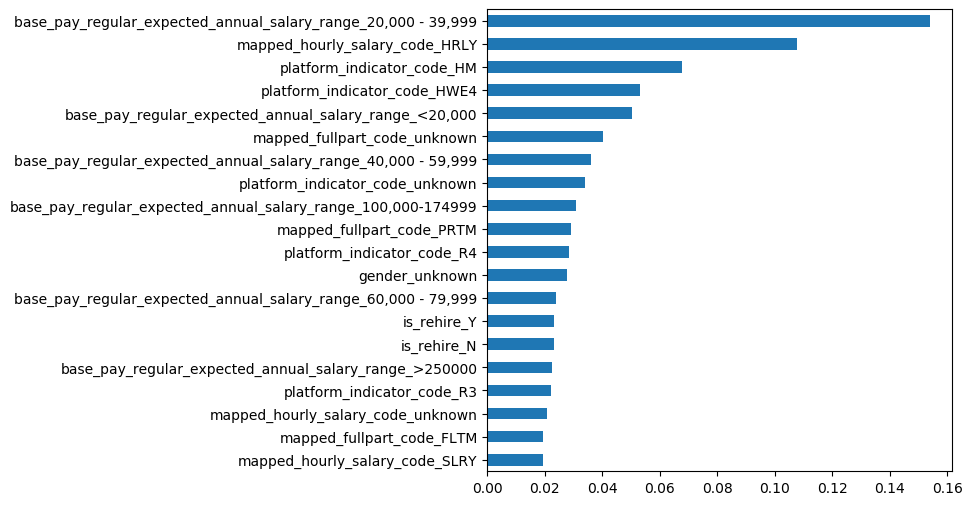

In [106]:
pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=True)[-20:].plot(kind='barh', figsize=(6,6))

In [107]:
def print_dataframe(df):
    
    """
    Print or display the entire dataframe
    
    Parameters
    ----------
    df: Dataframe
   
    Returns
    -------
    df: None
    
    """
    
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
        
    display(df)
    
    return None

In [108]:
# print_dataframe(test_set)

In [109]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [110]:
def load_and_test_models(X,y):
    
    X = X
    y = y
    
    # retrieve numpy array
    
    #data = df.values
    # split into input and output elements
#     X = df1.drop(['mapped_employment_status_code_label'],axis=1)
#     y = df1["mapped_employment_status_code_label"]


   # label encode the target variable to have the classes 0, 1, 2, etc.
    # This is already done for all cat features on in earlier statements.
    #y = LabelEncoder().fit_transform(y)
    
    #print('\nType of target _________ {}'.format(type_of_target(y)))
    




#     models = [RandomForestClassifier(n_estimators=1000),
#               LogisticRegression(), XGBClassifier(), DecisionTreeClassifier(), GaussianNB(), LGBMClassifier()]
    models = [rf,lr,dt,xgb,gnb,lgbm]
  
    # define evaluation procedure
    CV = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100)
    #CV = 5



   #index=range(CV * len(models))
    cv_df = pd.DataFrame()
   
    entries = []
    
    for model in models:
        
        model_name = model.__class__.__name__
        
        # evaluate model
        accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV, n_jobs=-1)
            
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))



    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    cv_df.accuracy*=100
    # summarize performance
    cv_df_mean_accuracy = pd.DataFrame(cv_df.groupby(['model_name']).agg({'accuracy': ['mean', 'std']}).reset_index())
    
    cv_df_mean_accuracy.columns = ['_'.join(col) for col in cv_df_mean_accuracy.columns]
    
    print_dataframe(cv_df_mean_accuracy)
    print('\n')
    
    # Plot model performance
    
    plt.figure(figsize=(15,6))



    sns.boxplot(x='model_name', y='accuracy', data=cv_df)



    sns.stripplot(x='model_name', y='accuracy', data=cv_df,
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
  #  plt.title("Accuracy ranging from 80-100%")
    #plt.ylim(80, 100)
    plt.show()

In [111]:
# X = test_set.drop(['mapped_employment_status_code_label'],axis=1
# y = test_set["mapped_employment_status_code_label"]

In [112]:
# X = test_set.drop(['target'],axis=1)
# y = test_set["target"]
# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_test.values, y_test.values, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
print('Accuracy: %.5f' % np.mean(scores))
print('STD: %.5f' % np.std(scores))

Accuracy: 0.80331
STD: 0.00149


model_name_  accuracy_mean  accuracy_std
0  DecisionTreeClassifier      78.581815      0.127310
1              GaussianNB      60.276595      0.384857
2          LGBMClassifier      80.172327      0.073002
3      LogisticRegression      77.049288      0.049044
4  RandomForestClassifier      78.477339      0.125633
5           XGBClassifier      80.323552      0.106181

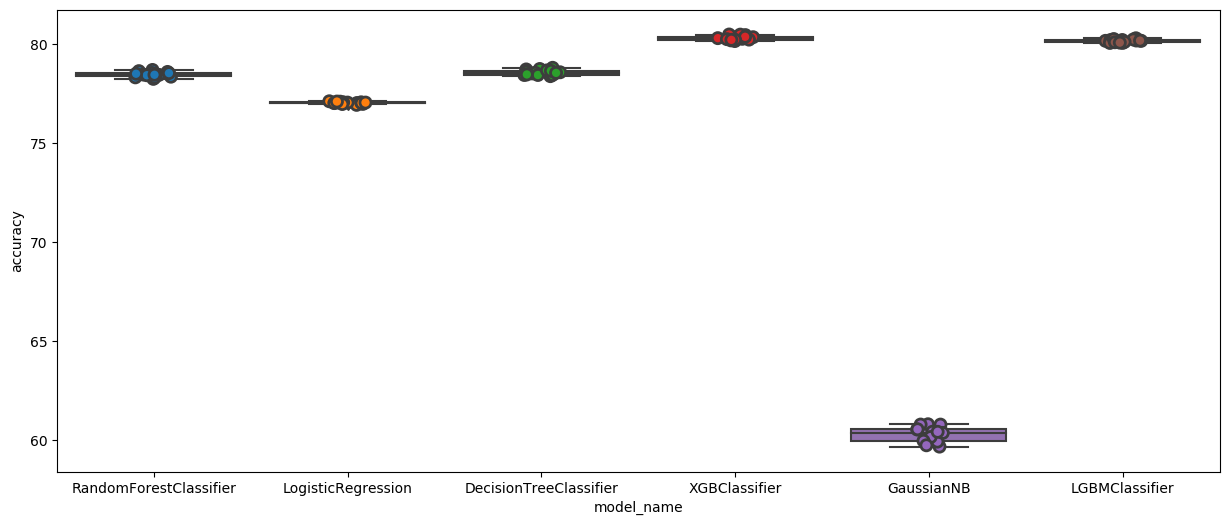

In [113]:
load_and_test_models(X_test.values,y_test.values)

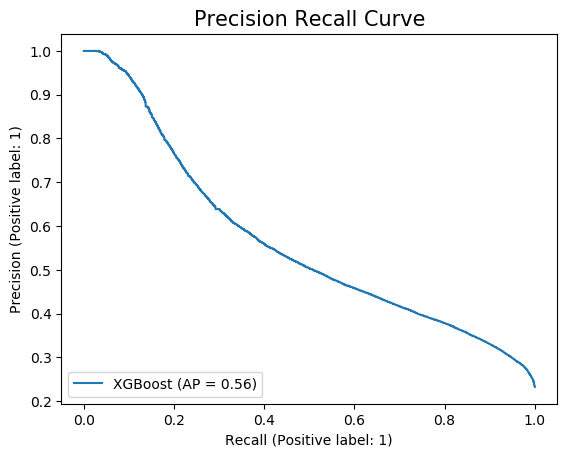

In [114]:
plot_precision_recall_curve(estimator=xgb, X=X_test, y=y_test, response_method='predict_proba', name='XGBoost')
plt.title('Precision Recall Curve', size=15)
# plt.savefig('Precision Recall Curve - XGBoost.png')
plt.show()

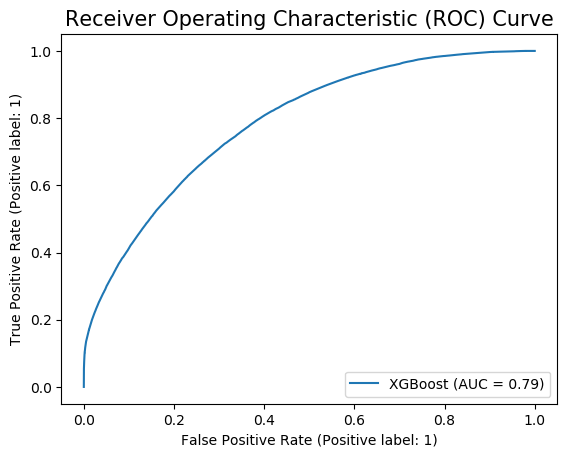

In [115]:
plot_roc_curve(estimator=xgb, X=X_test, y=y_test, response_method='predict_proba', name='XGBoost')
plt.title('Receiver Operating Characteristic (ROC) Curve', size=15)
# plt.savefig('Receiver Operating Characteristic (ROC) Curve.png')
plt.show()

#### Hyper-parameter Tunning using Baysian Search for XGBoost Model

#### Bayesian Optimization 1

In [116]:
seed = 112 # Random seed

def bayesian_optimization(train_X, train_y, eval_metrics=f1_score, cv=10):
    
    def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,gamma,subsample,colsample_bytree,min_child_weight):
#     def xgbc_cv(max_depth,learning_rate,n_estimators):
        # Storing function paramters in a dictionary which further will be passed to estimator function 
        hyperparameters = {
            'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            'n_estimators': int(n_estimators),
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'gamma': gamma,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'min_child_weight': min_child_weight
        }

        # Creating object of XGBClassifier class with paramters got as function parameters
        estimator_function = XGBClassifier(
            objective='binary:logistic',
            nthread = -1,
            seed = seed,
            **hyperparameters
        )


        # We are performing K-fold cross validation to tune hyper-parameters, target metrics = F1 score
        # We can change 'K' using `cv` parameter
        scores = cross_val_score(estimator=estimator_function, X=train_X.values, y=train_y, scoring=make_scorer(eval_metrics), cv=cv, error_score="raise")

        return scores.mean()

    
    hyperparameter_space = {
    'max_depth': (5, 15),
    'learning_rate': (0.01, 0.5),
    'n_estimators' : (50,150),
    'reg_alpha': (0.000001,2),
    'reg_lambda': (0.000001,2),
    'gamma': (0.0001,64),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.3, 1),
    'min_child_weight': (0,1)
    }

    modelBO = BayesianOptimization(f=xgbc_cv, pbounds=hyperparameter_space, random_state=seed, verbose=10)
    
    return modelBO

In [117]:
# By default evluation metrics is f1 score and cross-validations are 10
xgbcBO_ei = bayesian_optimization(X_train, y_train,cv=10)

In [118]:
%%time
gp_params = {"alpha": 1e-10}
# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points (init_points) to establish a 'prior', then will perform 
# 10 interations (n_iter) to maximize the value of estimator function
# xgbcBO_ei.maximize(init_points=3, n_iter=20, acq='ucb', kappa=3, **gp_params)
xgbcBO_ei.maximize(init_points=3, n_iter=10, acq='ei', xi=1e-4, **gp_params)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7228    | 0.5625    | 40.98     | 0.4755    | 5.757     | 0.7769    | 133.3     | 0.1096    | 1.635     | 0.9427    |
| 2         | 0.7327    | 0.8056    | 0.1637    | 0.4908    | 8.434     | 0.09476   | 89.46     | 0.009891  | 1.473     | 0.9779    |
| 3         | 0.7304    | 0.8744    | 22.08     | 0.1955    | 12.85     | 0.08623   | 104.6     | 0.3245    | 0.5801    | 0.5225    |
| 4         | 0.7273    | 0.3546    | 14.12     | 0.3663    | 12.9      | 0.595     | 78.27     | 1.493     | 0.7574    | 0.6235    |
| 5         | 0.7265    | 0.689     | 0.4511    | 0.1302    | 8.205     | 0.9158    | 90.92     | 0.9484    | 0.09262   | 0.5911    |
| 6         | 0.7291    | 0.4957    | 28.53     | 0.314     | 

In [119]:
xgbcBO_ei.max

{'target': 0.7395362076836631,
 'params': {'colsample_bytree': 1.0,
  'gamma': 0.0001,
  'learning_rate': 0.5,
  'max_depth': 11.40151214480158,
  'min_child_weight': 0.0,
  'n_estimators': 88.65324545664622,
  'reg_alpha': 1e-06,
  'reg_lambda': 2.0,
  'subsample': 1.0}}

In [120]:
# Fetching paramters corrosponding to best score (target)
# xgbcBO_best_param = xgbcBO.res[np.argmax([x['target'] for x in xgbcBO.res])]['params']
print(xgbcBO_ei.max)
xgbcBO_ei_best_param_ei = xgbcBO_ei.max['params']

{'target': 0.7395362076836631, 'params': {'colsample_bytree': 1.0, 'gamma': 0.0001, 'learning_rate': 0.5, 'max_depth': 11.40151214480158, 'min_child_weight': 0.0, 'n_estimators': 88.65324545664622, 'reg_alpha': 1e-06, 'reg_lambda': 2.0, 'subsample': 1.0}}


In [121]:
%%time
seed = 112 # Random seed

#creating object of XGBClassifier class with best hyper-parameters obtained from BayesianOptimization
xgbc_ei = XGBClassifier(
    max_depth=int(xgbcBO_ei_best_param_ei['max_depth']),
    learning_rate= round(xgbcBO_ei_best_param_ei['learning_rate'],2),
    n_estimators= int(xgbcBO_ei_best_param_ei['n_estimators']),
    reg_alpha = round(xgbcBO_ei_best_param_ei['reg_alpha'],2),
    reg_lambda = round(xgbcBO_ei_best_param_ei['reg_lambda'],2),
    gamma = round(xgbcBO_ei_best_param_ei['gamma'],2),
    subsample = round(xgbcBO_ei_best_param_ei['subsample'],2),
    colsample_bytree = round(xgbcBO_ei_best_param_ei['colsample_bytree'],2),
    nthread = -1,
    objective='binary:logistic',
    seed = seed)

# Fitting the model
xgbc_ei.fit(X_train.values, y_train)

CPU times: user 15min 39s, sys: 12.7 s, total: 15min 51s
Wall time: 59.9 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=88,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=112, reg_alpha=0.0, ...)

In [122]:
pred = xgbc_ei.predict(X_train)
print("XGBClassifier (TRAINING SET):\n", classification_report(y_train, pred))
print("ROC AUC score for data: ", roc_auc_score(y_train, pred))

XGBClassifier (TRAINING SET):
               precision    recall  f1-score   support

           0       0.76      0.70      0.73    795625
           1       0.72      0.78      0.75    795625

    accuracy                           0.74   1591250
   macro avg       0.74      0.74      0.74   1591250
weighted avg       0.74      0.74      0.74   1591250

ROC AUC score for data:  0.7390221523959152


In [123]:
pred = xgbc_ei.predict(X_test)
print("XGBClassifier (TESTING SET):\n", classification_report(y_test, pred))
print("ROC AUC score for data: ", roc_auc_score(y_test, pred))

XGBClassifier (TESTING SET):
               precision    recall  f1-score   support

           0       0.89      0.70      0.78    198907
           1       0.41      0.71      0.52     59207

    accuracy                           0.70    258114
   macro avg       0.65      0.70      0.65    258114
weighted avg       0.78      0.70      0.72    258114

ROC AUC score for data:  0.7047975838114907


#### Bayesian Optimization 2

In [124]:
seed = 112 # Random seed

def bayesian_optimization(train_X, train_y, eval_metrics=f1_score, cv=10):
    def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,gamma,subsample,colsample_bytree):
        # Storing function paramters in a dictionary which further will be passed to estimator function
        hyperparameters = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
        }
        # Creating object of XGBClassifier class with paramters got as function parameters
        estimator_function = XGBClassifier(
            objective='binary:logistic',
            nthread = -1,
            seed = seed,
            **hyperparameters
        )
        # We are performing K-fold cross validation to tune hyper-parameters, target metrics = F1 score
        # We can change 'K' using `cv` parameter
        scores = cross_val_score(estimator=estimator_function, X=X_train.values, y=y_train, scoring=make_scorer(eval_metrics), cv=cv, error_score="raise")
        return scores.mean()
    
    
    hyperparameter_space = {
        'max_depth': (3, 20),
        'learning_rate': (0.01, 0.3),
        'n_estimators' : (10,100),
        'reg_alpha': (0,1),
        'reg_lambda': (0, 1),
        'gamma': (0,0.5),
        'subsample': (0.5, 1),
        'colsample_bytree': (0.5, 1)
#       'colsample_bylevel': (0.5, 1),
     }

    modelBO = BayesianOptimization(f=xgbc_cv, pbounds=hyperparameter_space, random_state=seed, verbose=10)
    
    return modelBO


In [125]:
# By default evluation metrics is f1 score and cross-validations are 10
xgbcBO_ucb = bayesian_optimization(X_train, y_train,cv=10)

In [126]:
%%time
# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
xgbcBO_ucb.maximize(init_points=3,n_iter=10,acq='ucb', kappa= 3, **gp_params)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.707     | 0.6875    | 0.3202    | 0.2855    | 4.287     | 79.92     | 0.8327    | 0.05481   | 0.9088    |
| 2         | 0.7384    | 0.9427    | 0.3612    | 0.01074   | 19.68     | 40.91     | 0.09476   | 0.3946    | 0.5025    |
| 3         | 0.7276    | 0.8684    | 0.4779    | 0.248     | 8.865     | 44.07     | 0.7848    | 0.08623   | 0.773     |
| 4         | 0.7365    | 1.0       | 0.000329  | 0.01      | 20.0      | 23.36     | 0.0       | 1.0       | 0.5       |
| 5         | 0.6575    | 0.5       | 0.5       | 0.3       | 3.0       | 10.0      | 1.0       | 0.0       | 1.0       |
| 6         | 0.7374    | 1.0       | 0.0       | 0.01      | 20.0      | 59.19     | 0.0       | 1.0       | 0.5       |
| 7         | 0.737     

In [127]:
xgbcBO_best_param_ucb = xgbcBO_ucb.res[np.argmax([x['target'] for x in xgbcBO_ucb.res])]['params']
xgbcBO_best_param_ucb

{'colsample_bytree': 1.0,
 'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 20.0,
 'n_estimators': 78.52601768250321,
 'reg_alpha': 1.0,
 'reg_lambda': 1.0,
 'subsample': 0.5}

In [128]:
# Fetching paramters corrosponding to best score (target)
# xgbcBO_best_param = xgbcBO.res[np.argmax([x['target'] for x in xgbcBO.res])]['params']
print(xgbcBO_ucb.max)
xgbcBO_best_param_ucb = xgbcBO_ucb.max['params']

{'target': 0.7420973392955649, 'params': {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 20.0, 'n_estimators': 78.52601768250321, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.5}}


In [129]:
%%time
seed = 112
xgbc_ucb = XGBClassifier(max_depth=int(xgbcBO_best_param_ucb['max_depth']),
                       learning_rate= xgbcBO_best_param_ucb['learning_rate'],
                       n_estimators= int(xgbcBO_best_param_ucb['n_estimators']),
                       reg_alpha = xgbcBO_best_param_ucb['reg_alpha'],
                       gamma = xgbcBO_best_param_ucb['gamma'],
                       subsample = xgbcBO_best_param_ucb['subsample'],
                       colsample_bytree = xgbcBO_best_param_ucb['colsample_bytree'],
                       eval_metric = 'auc',
                       nthread = -1,
                       objective='binary:logistic',
                       seed = seed)

xgbc_ucb.fit(X_train.values, y_train)

CPU times: user 34min 31s, sys: 30.8 s, total: 35min 2s
Wall time: 2min 11s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=78,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=112, reg_alpha=1.0, ...)

In [130]:
pred = xgbc_ucb.predict(X_train)
print("XGBClassifier (TRAINING SET):\n", classification_report(y_train, pred))
print("ROC AUC score for data: ", roc_auc_score(y_train, pred))

XGBClassifier (TRAINING SET):
               precision    recall  f1-score   support

           0       0.77      0.70      0.73    795625
           1       0.73      0.79      0.75    795625

    accuracy                           0.74   1591250
   macro avg       0.75      0.74      0.74   1591250
weighted avg       0.75      0.74      0.74   1591250

ROC AUC score for data:  0.7443644933228594


In [131]:
pred = xgbc_ucb.predict(X_test)
print("XGBClassifier (TESTING SET):\n", classification_report(y_test, pred))
print("ROC AUC score for data: ", roc_auc_score(y_test, pred))

XGBClassifier (TESTING SET):
               precision    recall  f1-score   support

           0       0.89      0.69      0.78    198907
           1       0.40      0.70      0.51     59207

    accuracy                           0.69    258114
   macro avg       0.65      0.70      0.65    258114
weighted avg       0.78      0.69      0.72    258114

ROC AUC score for data:  0.6973882068908208


#### Bayesian Optimization 3

Splitting train set into train and val set, It is better to run bayesian optimization on less data instead on full as it is computaionally expensive

In [132]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42,stratify=y_train)

In [133]:
print(X_train_1.shape, y_train_1.shape, X_val_1.shape, y_val_1.shape)

(1273000, 33) (1273000,) (318250, 33) (318250,)


In [134]:
seed = 112 # Random seed

def bayesian_optimization(train_X, train_y, eval_metrics=f1_score, cv=10):
    def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,gamma,subsample,colsample_bytree):
        # Storing function paramters in a dictionary which further will be passed to estimator function
        hyperparameters = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree
        }
        # Creating object of XGBClassifier class with paramters got as function parameters
        estimator_function = XGBClassifier(
            objective='binary:logistic',
            nthread = -1,
            seed = seed,
            **hyperparameters
        )
        # We are performing K-fold cross validation to tune hyper-parameters, target metrics = F1 score
        # We can change 'K' using `cv` parameter
        scores = cross_val_score(estimator=estimator_function, X=X_train_1.values, y=y_train_1, scoring=make_scorer(eval_metrics), cv=cv, error_score="raise")
        return scores.mean()
    
    
    hyperparameter_space = {
        'max_depth': (3, 20),
        'learning_rate': (0.01, 0.3),
        'n_estimators' : (10,100),
        'reg_alpha': (0,1),
        'reg_lambda': (0, 1),
        'gamma': (0,0.5),
        'subsample': (0.5, 1),
        'colsample_bytree': (0.5, 1)
#       'colsample_bylevel': (0.5, 1),
     }

    modelBO = BayesianOptimization(f=xgbc_cv, pbounds=hyperparameter_space, random_state=seed, verbose=10)
    
    return modelBO


In [135]:
# By default evluation metrics is f1 score and cross-validations are 10
xgbcBO_ucb_1 = bayesian_optimization(X_train, y_train,cv=10)

In [136]:
%%time
# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
xgbcBO_ucb_1.maximize(init_points=3,n_iter=10,acq='ucb', kappa= 3, **gp_params)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7068    | 0.6875    | 0.3202    | 0.2855    | 4.287     | 79.92     | 0.8327    | 0.05481   | 0.9088    |
| 2         | 0.7367    | 0.9427    | 0.3612    | 0.01074   | 19.68     | 40.91     | 0.09476   | 0.3946    | 0.5025    |
| 3         | 0.7276    | 0.8684    | 0.4779    | 0.248     | 8.865     | 44.07     | 0.7848    | 0.08623   | 0.773     |
| 4         | 0.737     | 0.9412    | 0.1621    | 0.01      | 20.0      | 19.78     | 0.0       | 0.8275    | 0.5       |
| 5         | 0.6692    | 0.5       | 0.0       | 0.01      | 3.0       | 10.0      | 1.0       | 0.0       | 1.0       |
| 6         | 0.7375    | 1.0       | 0.3459    | 0.3       | 15.77     | 30.45     | 1.0       | 1.0       | 1.0       |
| 7         | 0.737     

In [137]:
xgbcBO_best_param_ucb_1 = xgbcBO_ucb_1.res[np.argmax([x['target'] for x in xgbcBO_ucb_1.res])]['params']
xgbcBO_best_param_ucb_1

{'colsample_bytree': 0.9969994235989537,
 'gamma': 0.3598078618700679,
 'learning_rate': 0.21724373277229053,
 'max_depth': 16.5334436168211,
 'n_estimators': 29.00784640896393,
 'reg_alpha': 0.9046741306464422,
 'reg_lambda': 0.8497348152099274,
 'subsample': 0.9207913415776496}

In [138]:
# Fetching paramters corrosponding to best score (target)
# xgbcBO_best_param = xgbcBO.res[np.argmax([x['target'] for x in xgbcBO.res])]['params']
print(xgbcBO_ucb_1.max)
xgbcBO_best_param_ucb_1 = xgbcBO_ucb_1.max['params']

{'target': 0.7383033684163445, 'params': {'colsample_bytree': 0.9969994235989537, 'gamma': 0.3598078618700679, 'learning_rate': 0.21724373277229053, 'max_depth': 16.5334436168211, 'n_estimators': 29.00784640896393, 'reg_alpha': 0.9046741306464422, 'reg_lambda': 0.8497348152099274, 'subsample': 0.9207913415776496}}


In [139]:
%%time
seed = 112
xgbc_ucb = XGBClassifier(max_depth=int(xgbcBO_best_param_ucb_1['max_depth']),
                       learning_rate= xgbcBO_best_param_ucb_1['learning_rate'],
                       n_estimators= int(xgbcBO_best_param_ucb_1['n_estimators']),
                       reg_alpha = xgbcBO_best_param_ucb_1['reg_alpha'],
                       gamma = xgbcBO_best_param_ucb_1['gamma'],
                       subsample = xgbcBO_best_param_ucb_1['subsample'],
                       colsample_bytree = xgbcBO_best_param_ucb_1['colsample_bytree'],
                       eval_metric = 'auc',
                       nthread = -1,
                       objective='binary:logistic',
                       seed = seed)

xgbc_ucb.fit(X_train.values, y_train)

CPU times: user 8min 53s, sys: 8.96 s, total: 9min 2s
Wall time: 34.3 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9969994235989537, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc',
              gamma=0.3598078618700679, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.21724373277229053, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=16, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=29, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              predictor='auto', random_state=112, reg_alpha=0.9046741306464422, ...)

In [140]:
pred = xgbc_ucb.predict(X_train_1)
print("XGBClassifier (TRAINING SET):\n", classification_report(y_train_1, pred))
print("ROC AUC score for data: ", roc_auc_score(y_train_1, pred))

XGBClassifier (TRAINING SET):
               precision    recall  f1-score   support

           0       0.75      0.70      0.73    636500
           1       0.72      0.77      0.74    636500

    accuracy                           0.74   1273000
   macro avg       0.74      0.74      0.74   1273000
weighted avg       0.74      0.74      0.74   1273000

ROC AUC score for data:  0.7356166535742341


In [141]:
pred = xgbc_ucb.predict(X_val_1)
print("XGBClassifier (TRAINING SET):\n", classification_report(y_val_1, pred))
print("ROC AUC score for data: ", roc_auc_score(y_val_1, pred))

XGBClassifier (TRAINING SET):
               precision    recall  f1-score   support

           0       0.75      0.70      0.73    159125
           1       0.72      0.77      0.74    159125

    accuracy                           0.73    318250
   macro avg       0.74      0.73      0.73    318250
weighted avg       0.74      0.73      0.73    318250

ROC AUC score for data:  0.7349347996857815


In [142]:
pred = xgbc_ucb.predict(X_test)
print("XGBClassifier (TESTING SET):\n", classification_report(y_test, pred))
print("ROC AUC score for data: ", roc_auc_score(y_test, pred))

XGBClassifier (TESTING SET):
               precision    recall  f1-score   support

           0       0.89      0.69      0.78    198907
           1       0.41      0.72      0.52     59207

    accuracy                           0.70    258114
   macro avg       0.65      0.71      0.65    258114
weighted avg       0.78      0.70      0.72    258114

ROC AUC score for data:  0.7076854372650851


### Fitting XGBoost Model with Best Paramaters

In [234]:
# %%time
# seed = 112 # Random seed

# #creating object of XGBClassifier class with best hyper-parameters obtained from BayesianOptimization
# xgbc_best = XGBClassifier(
#     objective='binary:logistic',
#     reg_alpha= 0.3145861684449107,
#     colsample_bytree=0.7061972343137226,
#     eta=0.220003319667584413,
#     gamma=0.2621664021277470,
#     reg_lambda=0.5855970898794325,
#     max_depth=20,
#     subsample = 0.6585626731290724,
#     seed = seed)

# # Fitting the model
# xgbc_best.fit(X_train.values, y_train)

CPU times: user 32min 17s, sys: 32.4 s, total: 32min 49s
Wall time: 2min 3s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7061972343137226, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2200033196675844,
              eval_metric=None, gamma=0.262166402127747, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.220003322,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=20,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=112,
              reg_alpha=0.3145861684449107, ...)

In [237]:
%%time
seed = 112 # Random seed

#creating object of XGBClassifier class with best hyper-parameters obtained from BayesianOptimization
xgbc_best = XGBClassifier(
    objective='binary:logistic',
    reg_alpha= 0.9046741306464422,
    colsample_bytree=0.9969994235989537,
    eta=0.217243732772290533,
    gamma=0.3598078618700679,
    reg_lambda=0.8497348152099274,
    max_depth=17,
    subsample = 0.9207913415776496,
    seed = seed)

# Fitting the model
xgbc_best.fit(X_train.values, y_train)

CPU times: user 32min 48s, sys: 28.6 s, total: 33min 16s
Wall time: 2min 5s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9969994235989537, early_stopping_rounds=None,
              enable_categorical=False, eta=0.21724373277229053,
              eval_metric=None, gamma=0.3598078618700679, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.217243731,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=17,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=112,
              reg_alpha=0.9046741306464422, ...)

In [238]:
pred_train = xgbc_best.predict(X_train)
print("XGBClassifier (TRAINING SET):\n", classification_report(y_train, pred_train))
print("ROC AUC score for data: ", roc_auc_score(y_train, xgbc_best.predict_proba(X_train)[:,1], average='weighted'))

XGBClassifier (TRAINING SET):
               precision    recall  f1-score   support

           0       0.77      0.70      0.73    795625
           1       0.73      0.78      0.75    795625

    accuracy                           0.74   1591250
   macro avg       0.75      0.74      0.74   1591250
weighted avg       0.75      0.74      0.74   1591250

ROC AUC score for data:  0.8356285350088027


In [239]:
pred_test = xgbc_best.predict(X_test)
print("XGBClassifier (TESTING SET):\n", classification_report(y_test, pred_test))
print("ROC AUC score for data: ", roc_auc_score(y_test, xgbc_best.predict_proba(X_test)[:,1], average='weighted'))

XGBClassifier (TESTING SET):
               precision    recall  f1-score   support

           0       0.89      0.69      0.78    198907
           1       0.41      0.71      0.52     59207

    accuracy                           0.70    258114
   macro avg       0.65      0.70      0.65    258114
weighted avg       0.78      0.70      0.72    258114

ROC AUC score for data:  0.7791203110908186


#### Results on Train Set

In [147]:
print('Metrics Score on best XGBoost model on Training Set')
print('Recall:'.ljust(20, " "),recall_score(y_train, pred_train, average='weighted'))
print('Precision: '.ljust(20, " "),precision_score(y_train, pred_train, average='weighted'))
print('F1: '.ljust(20, " "),f1_score(y_train, pred_train, average='weighted'))
print('Simple Accuracy: '.ljust(20, " "),accuracy_score(y_train, pred_train))
print('ROC AUC: '.ljust(20, " "),roc_auc_score(y_train, xgbc_best.predict_proba(X_train)[:,1], average='weighted'))
print('AUPRC: '.ljust(20, " "),average_precision_score(y_train, xgbc_best.predict_proba(X_train)[:,1], average='weighted'))

Metrics Score on best XGBoost model on Training Set
Recall:              0.7442991358994501
Precision:           0.745846557988709
F1:                  0.743896139846151
Simple Accuracy:     0.7442991358994501
ROC AUC:             0.8356285350088027
AUPRC:               0.8356842478759637


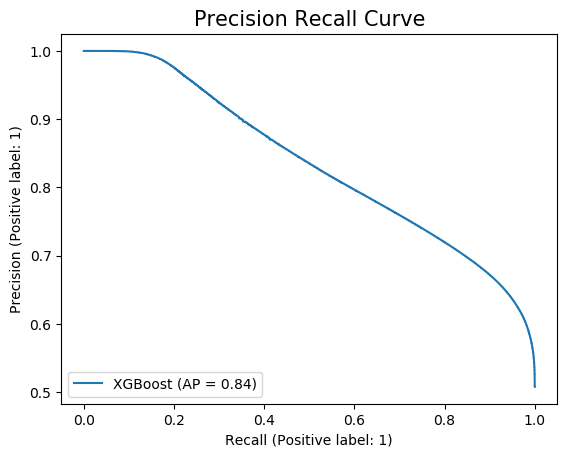

In [148]:
plot_precision_recall_curve(estimator=xgbc_best, X=X_train, y=y_train, response_method='predict_proba', name='XGBoost')
plt.title('Precision Recall Curve', size=15)
# plt.savefig('Precision Recall Curve - XGBoost.png')
plt.show()

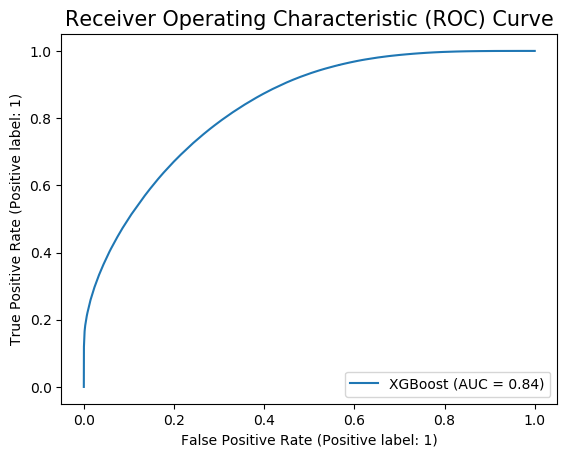

In [149]:
plot_roc_curve(estimator=xgbc_best, X=X_train, y=y_train, response_method='predict_proba', name='XGBoost')
plt.title('Receiver Operating Characteristic (ROC) Curve', size=15)
# plt.savefig('Receiver Operating Characteristic (ROC) Curve.png')
plt.show()

In [150]:
# plot_confusion_matrix(estimator=xgbc_best, X=X_train, y_true=y_train, cmap='green',values_format='.0f')
# plt.title('Confusion Matrix', size=15)
# # plt.savefig('Confusion Matrix.png')
# plt.show()

#### Results on Test Set

In [151]:
print('Metrics Score on best XGBoost model on Testing Set')
print('Recall:'.ljust(20, " "),recall_score(y_test, pred_test, average='weighted'))
print('Precision: '.ljust(20, " "),precision_score(y_test, pred_test, average='weighted'))
print('F1: '.ljust(20, " "),f1_score(y_test, pred_test, average='weighted'))
print('Simple Accuracy: '.ljust(20, " "),accuracy_score(y_test, pred_test))
print('ROC AUC: '.ljust(20, " "),roc_auc_score(y_test, xgbc_best.predict_proba(X_test)[:,1], average='weighted'))
print('AUPRC: '.ljust(20, " "),average_precision_score(y_test, xgbc_best.predict_proba(X_test)[:,1], average='weighted'))

Metrics Score on best XGBoost model on Testing Set
Recall:              0.6973662800158069
Precision:           0.7779573808087803
F1:                  0.7194015051165954
Simple Accuracy:     0.6973662800158069
ROC AUC:             0.7791203110908186
AUPRC:               0.5598358603684648


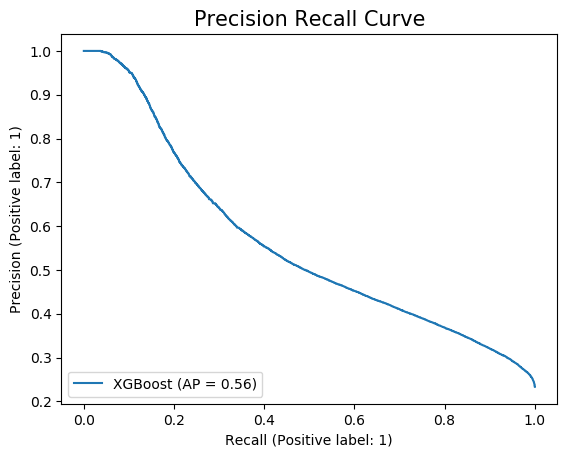

In [152]:
plot_precision_recall_curve(estimator=xgbc_best, X=X_test, y=y_test, response_method='predict_proba', name='XGBoost')
plt.title('Precision Recall Curve', size=15)
# plt.savefig('Precision Recall Curve - XGBoost.png')
plt.show()

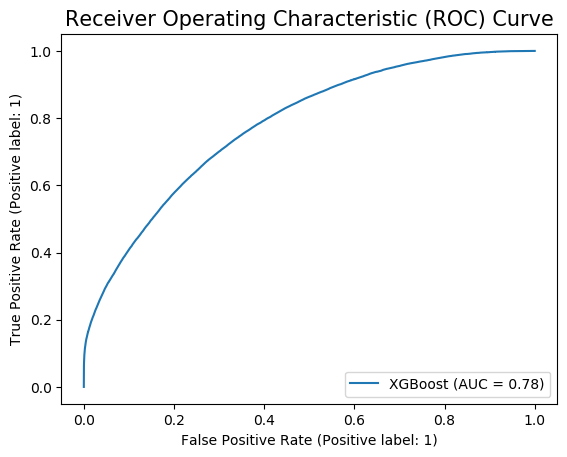

In [153]:
plot_roc_curve(estimator=xgbc_best, X=X_test, y=y_test, response_method='predict_proba', name='XGBoost')
plt.title('Receiver Operating Characteristic (ROC) Curve', size=15)
# plt.savefig('Receiver Operating Characteristic (ROC) Curve.png')
plt.show()

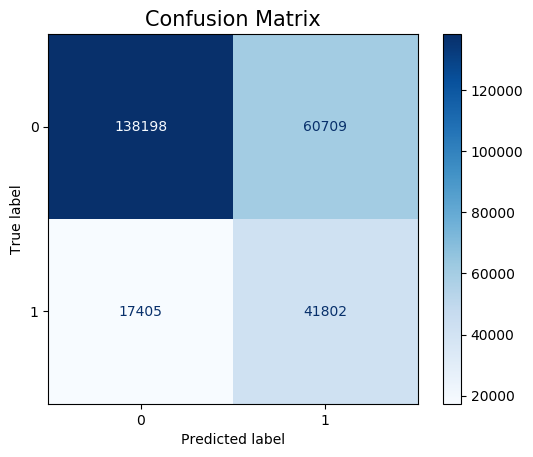

In [154]:
plot_confusion_matrix(estimator=xgbc_best, X=X_test, y_true=y_test, cmap='Blues',values_format='.0f')
plt.title('Confusion Matrix', size=15)
# plt.savefig('Confusion Matrix.png')
plt.show()

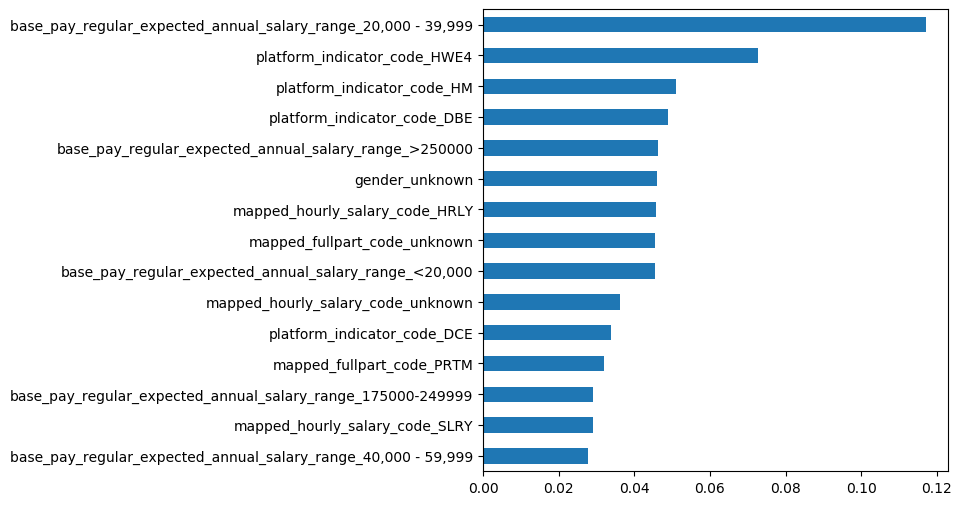

In [155]:
pd.Series(xgbc_best.feature_importances_, index=X_train.columns).sort_values(ascending=True)[-15:].plot(kind='barh', figsize=(6,6))
# plt.savefig('Feature Importance XGBoost.png')
plt.show()

Bagging Classifier:

In [156]:
 from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=xgbc_best,n_estimators=10,random_state=0).fit(X_train, y_train)

In [157]:
y_pred_xgb_clf = clf.predict(X_test)

## Saving Final (Best) ML Model

In [158]:
# # WRITE
# s3_client = boto3.client('s3')

# with tempfile.TemporaryFile() as fp:
#     joblib.dump(xgb, fp)
#     fp.seek(0)
#     s3_client.put_object(Body=fp.read(), Bucket=bucket, Key=model_name_and_path)
# print(f'Model saved at this location ------> s3://{bucket}/{model_name_and_path}')

In [159]:
# # READ
# s3_client = boto3.client('s3')

# with tempfile.TemporaryFile() as fp:
#     s3_client.download_fileobj(Fileobj=fp, Bucket=bucket, Key=model_name_and_path)
#     fp.seek(0)
#     model = joblib.load(fp)

## Using SHAP values to interpret the model

In [160]:
# Fits the explainer
explainer = shap.Explainer(xgbc_best.predict, X_test[:2000])
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test[:2000])

Permutation explainer: 2001it [03:02, 10.95it/s]                          


In [161]:
pred_prob = xgbc_best.predict(X_test[:2000])

In [162]:
pred_prob.mean()

0.3935

In [163]:
shap_values.base_values

array([0.41, 0.41, 0.41, ..., 0.41, 0.41, 0.41])

In [164]:
shap.initjs()
shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=X_test.columns)

In [165]:
shap.plots.force(shap_values.base_values[2],shap_values.values[2], feature_names=X_test.columns)

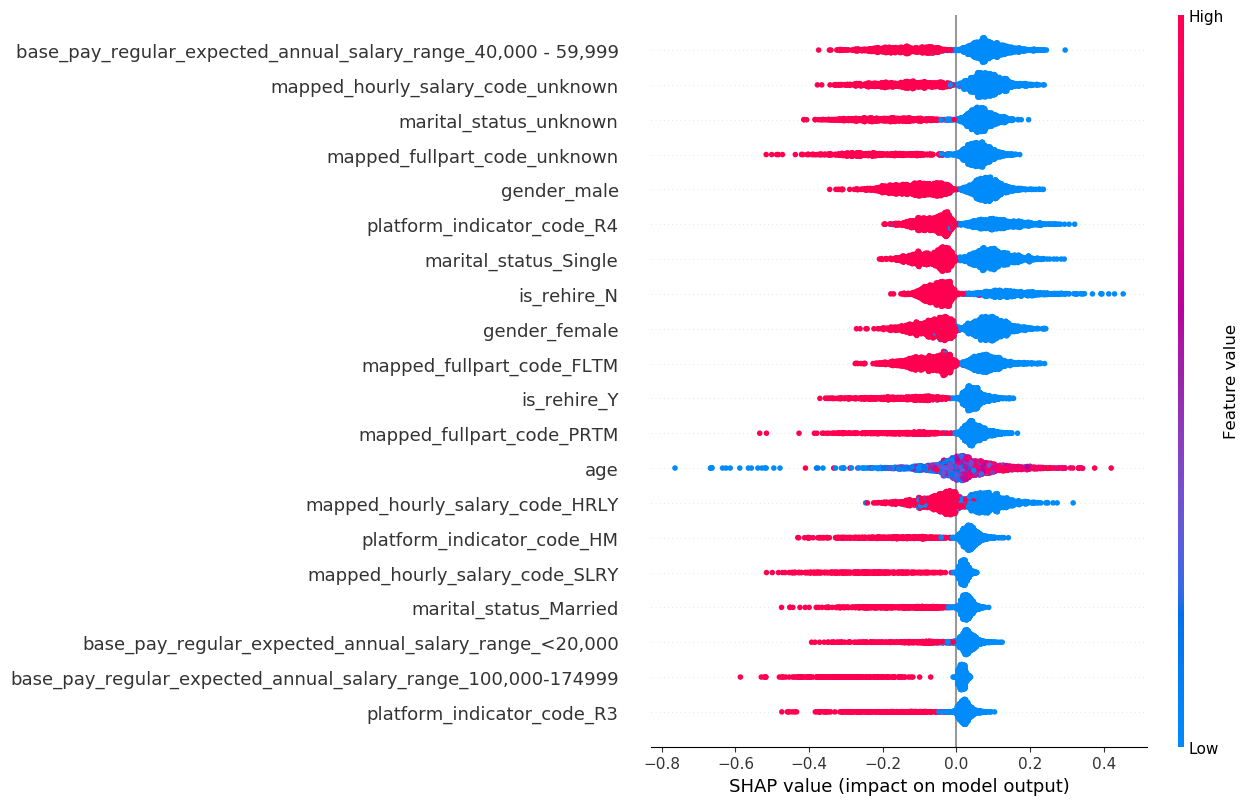

In [166]:
f = plt.figure()
shap.summary_plot(shap_values)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

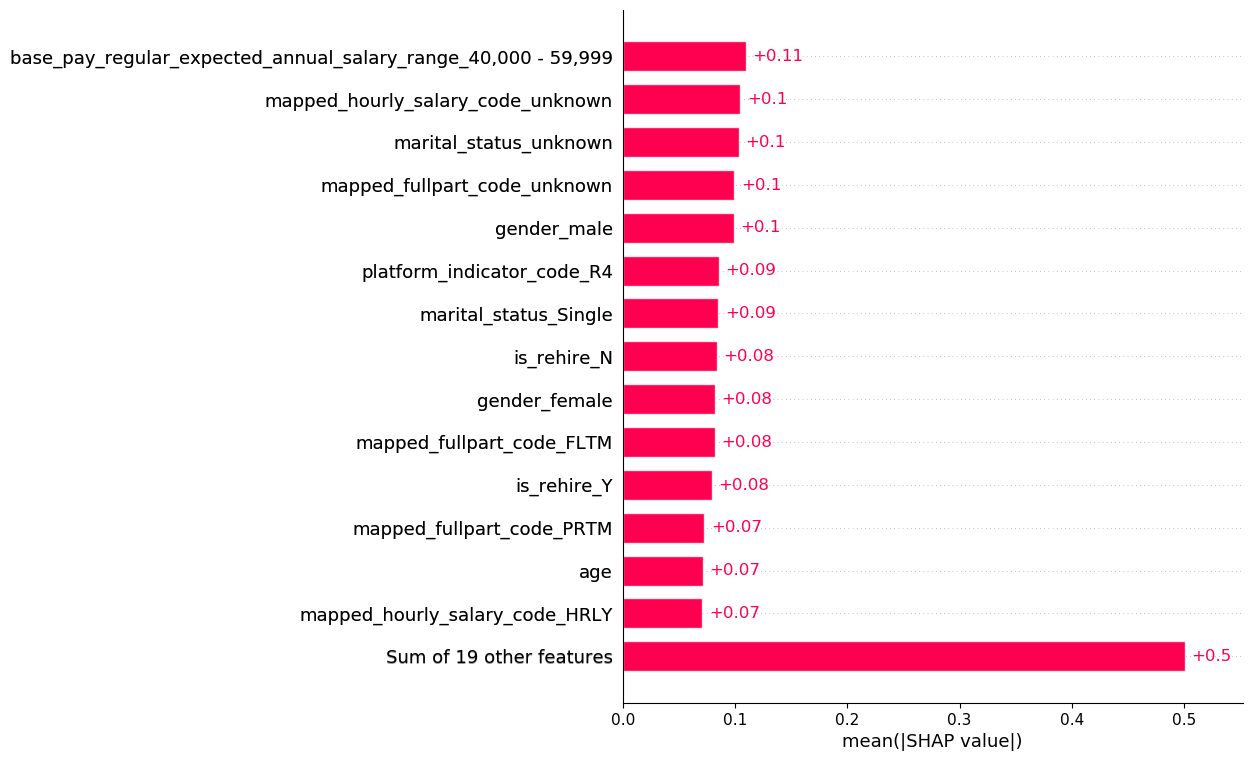

In [167]:
f = plt.figure()
shap.plots.bar(shap_values, max_display=15)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [168]:
shap_df = pd.DataFrame(shap_values.values, columns=X_train.columns)
shap_df.shape

(2000, 33)

In [169]:
shap_df.head()

age  gender_male  gender_female  gender_unknown  \
0  0.048333     0.078333      -0.077500             0.0   
1 -0.001667     0.034167      -0.021667             0.0   
2  0.019167     0.067500      -0.029167             0.0   
3  0.135000     0.070833      -0.016667             0.0   
4 -0.143333    -0.110000       0.055833             0.0   

   marital_status_unknown  marital_status_Married  marital_status_Single  \
0                0.069167                0.030833              -0.014167   
1                0.132500                0.023333              -0.030833   
2                0.106667               -0.080833               0.114167   
3               -0.065833                0.038333               0.155000   
4                0.061667                0.048333              -0.085000   

   marital_status_Divorced  is_union_N  is_union_Y  \
0                      0.0         0.0         0.0   
1                      0.0         0.0         0.0   
2                      0.0         0.0         0.0   
3                      0.0         0.0         0.0   
4                      0.0         0.0         0.0   

   platform_indicator_code_HM  platform_indicator_code_R4  \
0                    0.057500                    0.015000   
1                    0.069167                   -0.020000   
2                    0.064167                    0.147500   
3                   -0.143333                    0.011667   
4                    0.066667                    0.045000   

   platform_indicator_code_unknown  platform_indicator_code_DBE  \
0                        -0.167500                          0.0   
1                         0.012500                          0.0   
2                         0.015833                          0.0   
3                         0.010000                          0.0   
4                        -0.340000                          0.0   

   platform_indicator_code_DCE  platform_indicator_code_R3  \
0                          0.0                    0.034167   
1                          0.0                    0.055833   
2                          0.0                   -0.115833   
3                          0.0                    0.010000   
4                          0.0                   -0.025000   

   platform_indicator_code_HWE4  mapped_fullpart_code_FLTM  \
0                      0.009167                   0.001667   
1                      0.003333                   0.052500   
2                      0.009167                  -0.050000   
3                      0.009167                  -0.020000   
4                      0.004167                  -0.107500   

   mapped_fullpart_code_unknown  mapped_fullpart_code_PRTM  \
0                      0.084167                   0.147500   
1                      0.065000                  -0.105000   
2                      0.098333                   0.037500   
3                      0.066667                   0.058333   
4                      0.028333                   0.053333   

   mapped_hourly_salary_code_HRLY  mapped_hourly_salary_code_unknown  \
0                       -0.038333                           0.238333   
1                       -0.010000                           0.146667   
2                       -0.085000                           0.050000   
3                       -0.046667                           0.111667   
4                       -0.012500                          -0.036667   

   mapped_hourly_salary_code_SLRY  is_rehire_Y  is_rehire_N  \
0                        0.048333     0.050833    -0.032500   
1                        0.031667    -0.154167     0.175000   
2                        0.022500     0.053333    -0.028333   
3                        0.025833     0.024167    -0.045833   
4                        0.010000     0.044167    -0.103333   

   base_pay_regular_expected_annual_salary_range_40,000 - 59,999  \
0                                          -0.135833               
1                                 

In [170]:
data_df = pd.DataFrame(shap_values.data, columns=X_train.columns)
data_df.shape

(2000, 33)

In [171]:
data_df.head(3)

age  gender_male  gender_female  gender_unknown  marital_status_unknown  \
0   39            0              1               0                       0   
1   51            0              1               0                       0   
2   46            0              1               0                       0   

   marital_status_Married  marital_status_Single  marital_status_Divorced  \
0                       0                      1                        0   
1                       0                      1                        0   
2                       1                      0                        0   

   is_union_N  is_union_Y  platform_indicator_code_HM  \
0           1           0                           0   
1           1           0                           0   
2           1           0                           0   

   platform_indicator_code_R4  platform_indicator_code_unknown  \
0                           0                                1   
1                           1                                0   
2                           0                                0   

   platform_indicator_code_DBE  platform_indicator_code_DCE  \
0                            0                            0   
1                            0                            0   
2                            0                            0   

   platform_indicator_code_R3  platform_indicator_code_HWE4  \
0                           0                             0   
1                           0                             0   
2                           1                             0   

   mapped_fullpart_code_FLTM  mapped_fullpart_code_unknown  \
0                          1                             0   
1                          0                             0   
2                          1                             0   

   mapped_fullpart_code_PRTM  mapped_hourly_salary_code_HRLY  \
0                          0                               1   
1                          1                               1   
2                          0                               1   

   mapped_hourly_salary_code_unknown  mapped_hourly_salary_code_SLRY  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   

   is_rehire_Y  is_rehire_N  \
0            0            1   
1            1            0   
2            0            1   

   base_pay_regular_expected_annual_salary_range_40,000 - 59,999  \
0                                                  1               
1                                                  0               
2                                                  0               

   base_pay_regular_expected_annual_salary_range_60,000 - 79,999  \
0                                                  0               
1                                                  0               
2                                                  0               

   base_pay_regular_expected_annual_salary_range_20,000 - 39,999  \
0                                                  0               
1                                                  1               
2                                                  0               

   base_pay_regular_expected_annual_salary_range_<20,000  \
0                                                  0       
1                                                  0       
2                                                  1       

   base_pay_regular_expected_annual_salary_range_80,000 - 99,999  \
0                                                  0               
1                                                  0               
2                                                  0               

   base_pay_regular_expected_annual_salary_range_100,000-174999  \
0                                                  0         

In [172]:
corr_coef = []
for col in X_train.columns:
    corr_coef.append(np.corrcoef(shap_df[col],data_df[col])[1][0])

In [173]:
color_list = ['blue' if i>0 else 'red' for i in corr_coef]

In [174]:
plot_df = pd.DataFrame(shap_df.abs().mean(axis=0), columns=['mean(|SHAP values|)'])
plot_df['corr_coef'] = corr_coef
plot_df['corr color'] = color_list
plot_df = plot_df.sort_values('mean(|SHAP values|)', ascending=True).reset_index()
plot_df = plot_df.iloc[-10:,:]
colorlist = plot_df['corr color']

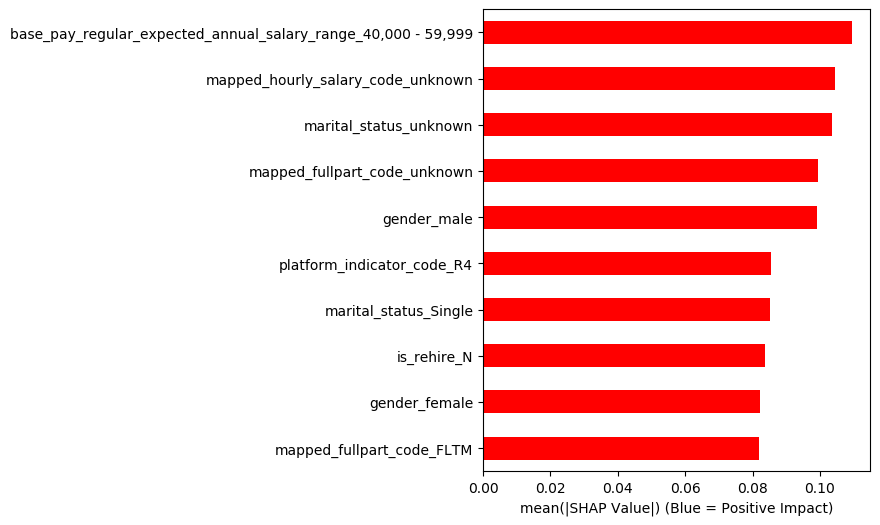

In [175]:
# f = plt.figure()
plot_df.plot.barh(x='index', y='mean(|SHAP values|)',color=colorlist, figsize=(5,6), legend=False)
plt.xlabel("mean(|SHAP Value|) (Blue = Positive Impact)")
plt.ylabel('')
plt.savefig('shap.png',bbox_inches='tight', dpi=600)
plt.show()

In [176]:
# Fits the explainer
explainer = shap.Explainer(xgbc_best.predict, X_test[:2000])
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test[:2000])

Permutation explainer: 2001it [02:56, 11.32it/s]                          


In [177]:
pred = xgbc_best.predict(X_test[:2000])

In [178]:
pred .mean()

0.3935

In [179]:
shap_values.base_values

array([0.41, 0.41, 0.41, ..., 0.41, 0.41, 0.41])

In [180]:
# shap.initjs()
# shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=test_X.columns)

In [181]:
# shap.plots.force(shap_values.base_values[2],shap_values.values[2], feature_names=test_X.columns)

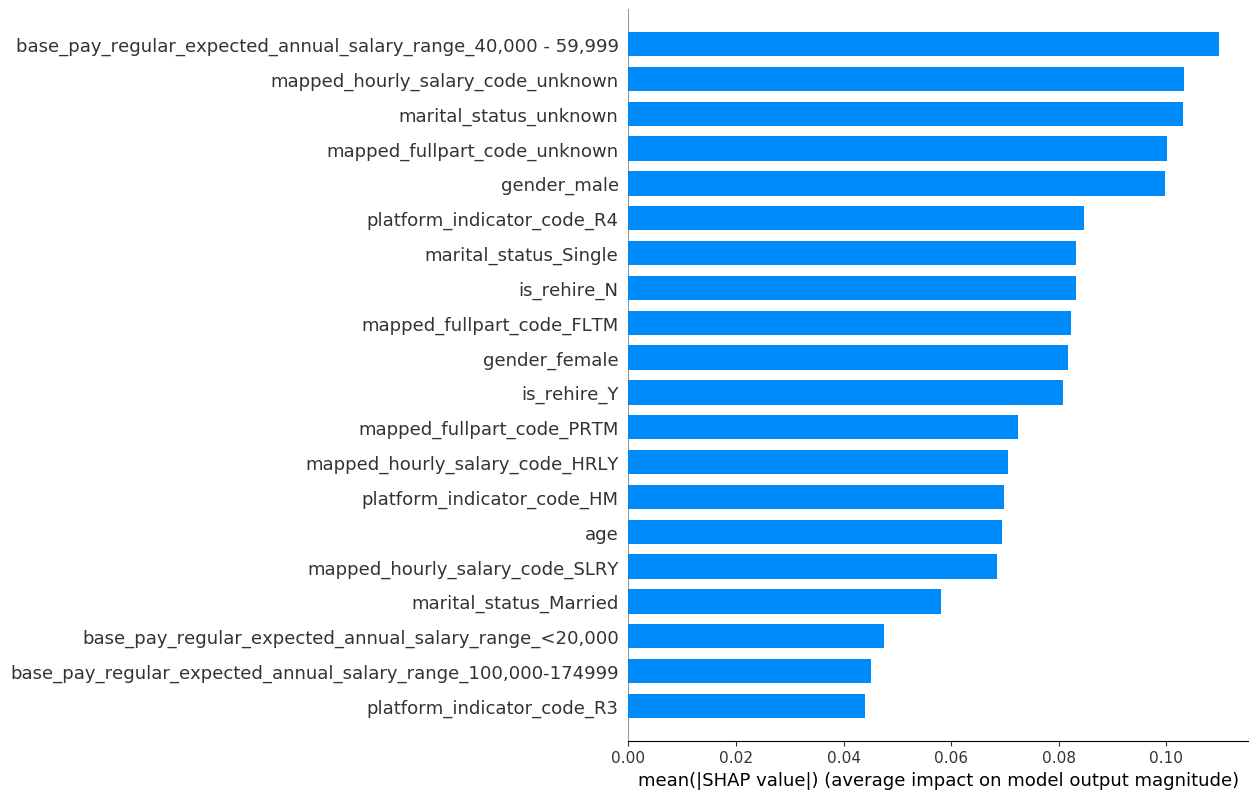

In [182]:
f = plt.figure()
shap.summary_plot(shap_values,plot_type="bar")
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

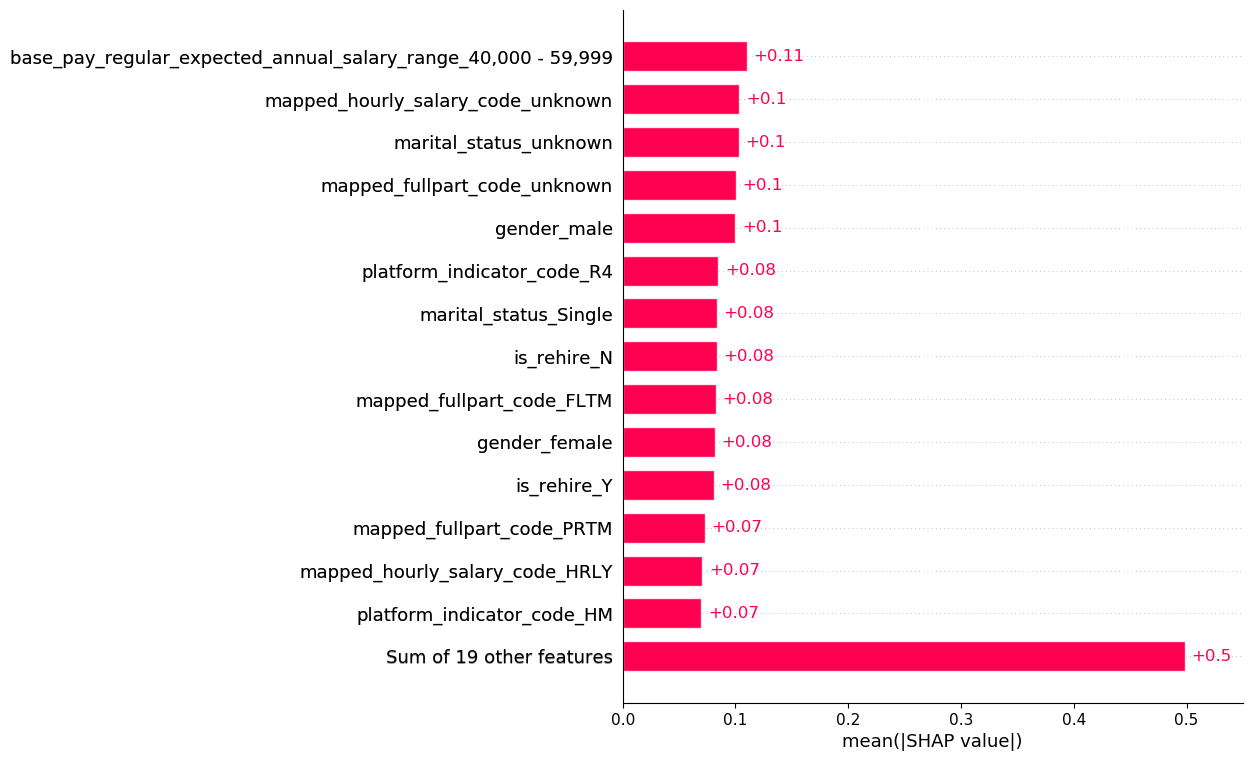

In [183]:
f = plt.figure()
shap.plots.bar(shap_values, max_display=15)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [184]:
# Fits the explainer
explainer1 = shap.TreeExplainer(xgbc_best, model_output="margin")
# Calculates the SHAP values - It takes some time
shap_values1 = explainer1.shap_values(X_test[:200].values)

In [185]:
shap_values1.base

array([-0.09844163,  0.2852222 , -0.23274548, ...,  0.05090213,
        0.02781958, -0.00265413], dtype=float32)

In [186]:
np.mean(np.abs(shap_values1))

0.29601932

In [187]:
explainer1.expected_value

-0.0026541254

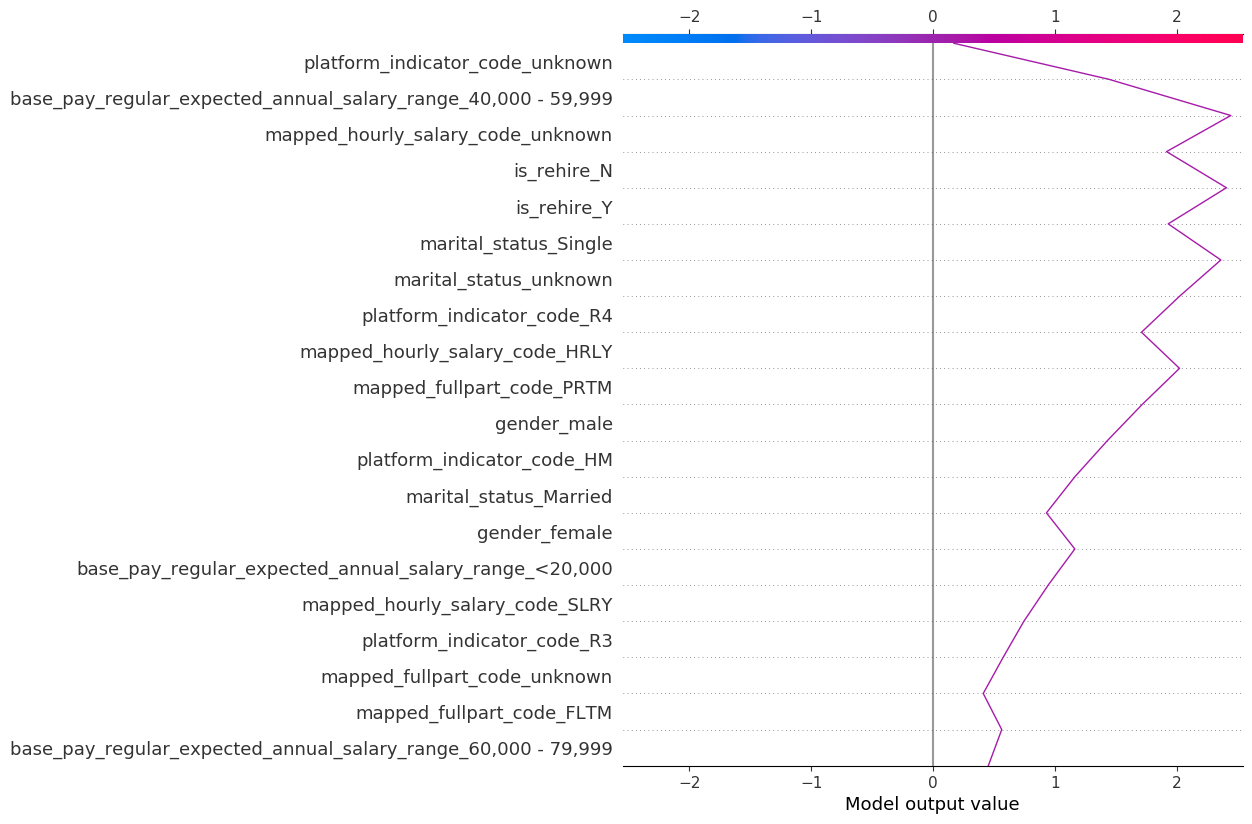

In [188]:
shap.decision_plot(base_value=explainer1.expected_value,shap_values=shap_values1[0],feature_names=X_test.columns.tolist())

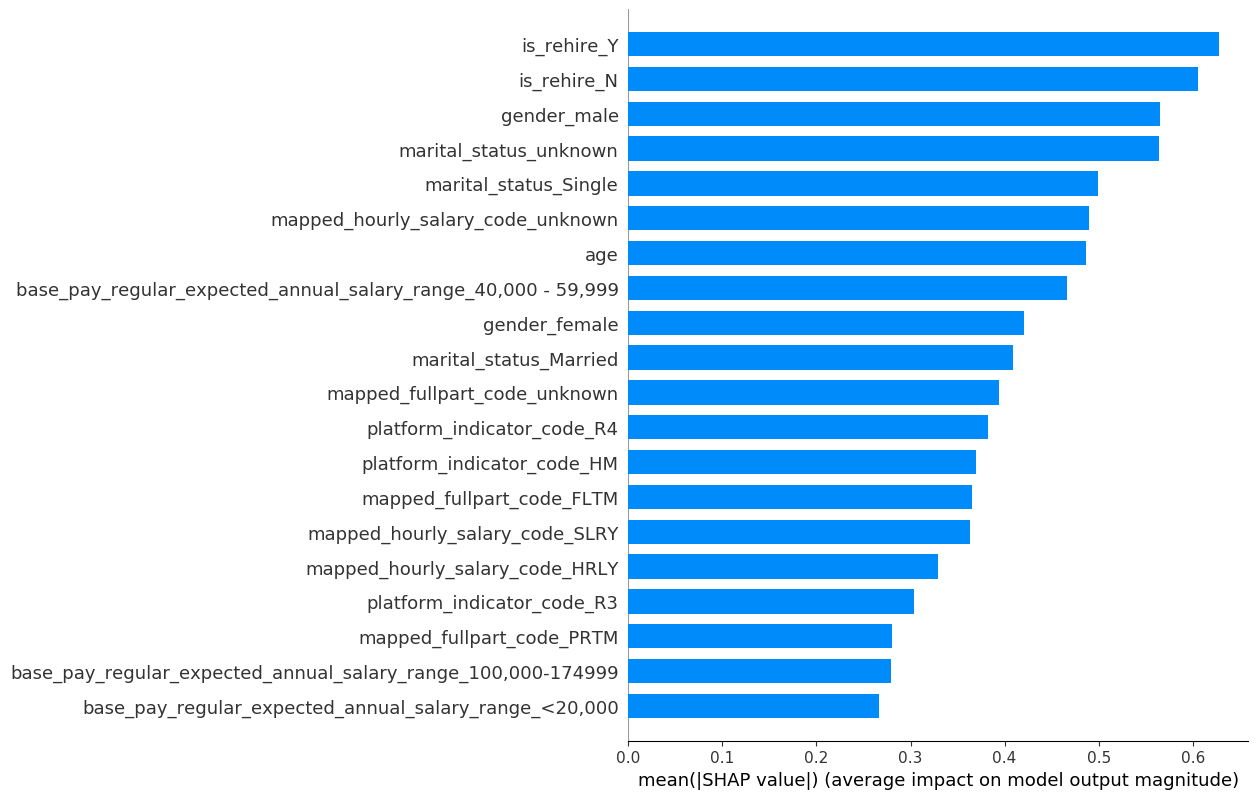

In [189]:
shap.summary_plot(shap_values1, X_test[:100], plot_type="bar")

In [190]:
pred.mean()

0.3935

In [191]:
shap_values.base_values

array([0.41, 0.41, 0.41, ..., 0.41, 0.41, 0.41])

In [192]:
shap.initjs()
shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=X_test.columns)

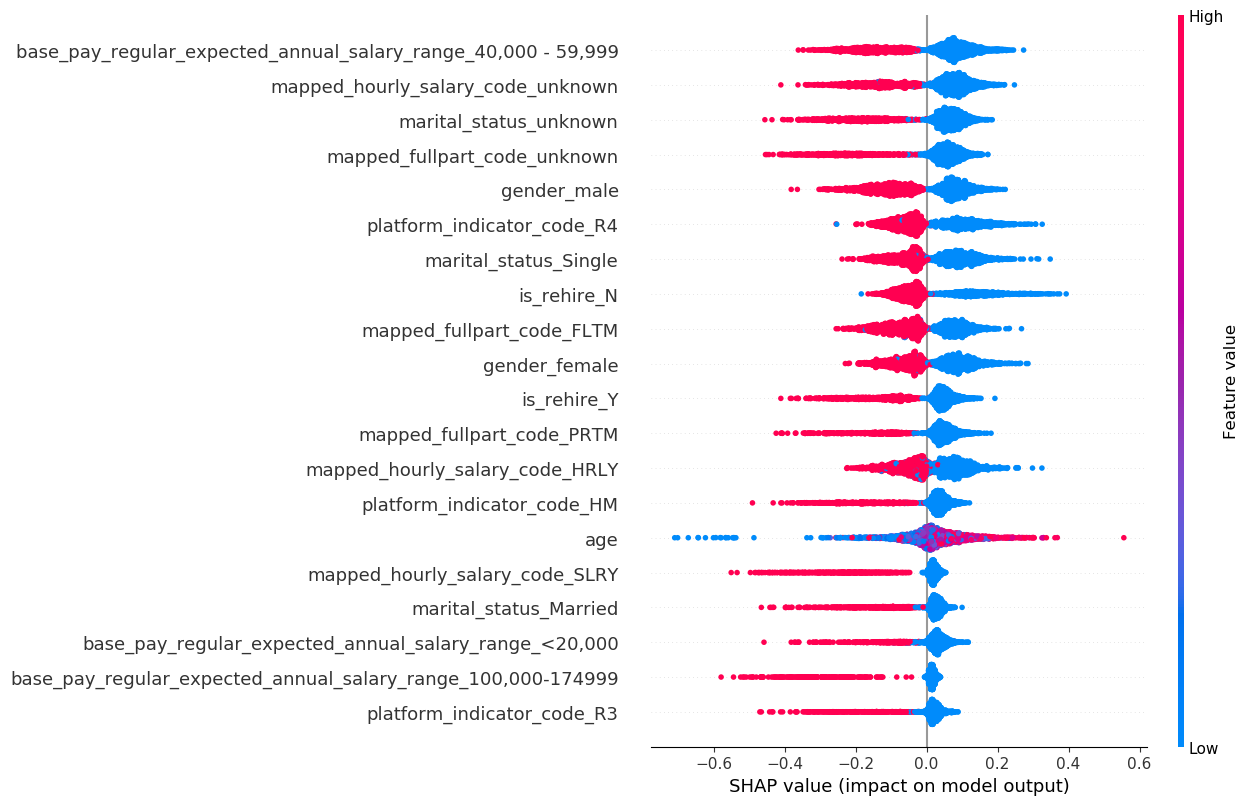

In [193]:
f = plt.figure()
shap.summary_plot(shap_values)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

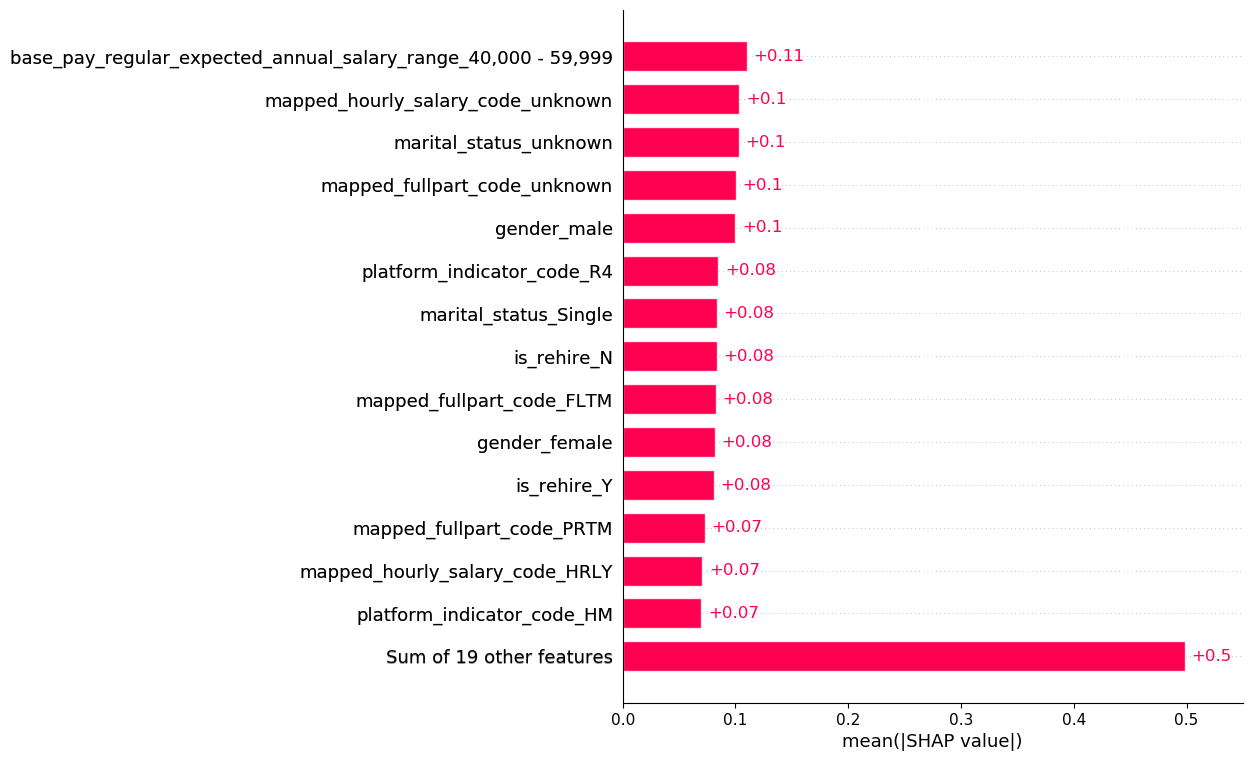

In [194]:
f = plt.figure()
shap.plots.bar(shap_values, max_display=15)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [195]:
%%time
# Fits the explainer
explainer = shap.Explainer(xgbc_best)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test[:100])

CPU times: user 52 s, sys: 122 ms, total: 52.1 s
Wall time: 26.7 s


In [196]:
pred_prob = xgbc_best.predict(X_test[:100])

In [197]:
pred_prob.mean()

0.42

In [198]:
shap_values.base_values

array([-0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00

In [199]:
shap.initjs()
shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=X_test.columns)

In [200]:
shap.plots.force(shap_values.base_values[5],shap_values.values[0], feature_names=X_test.columns)

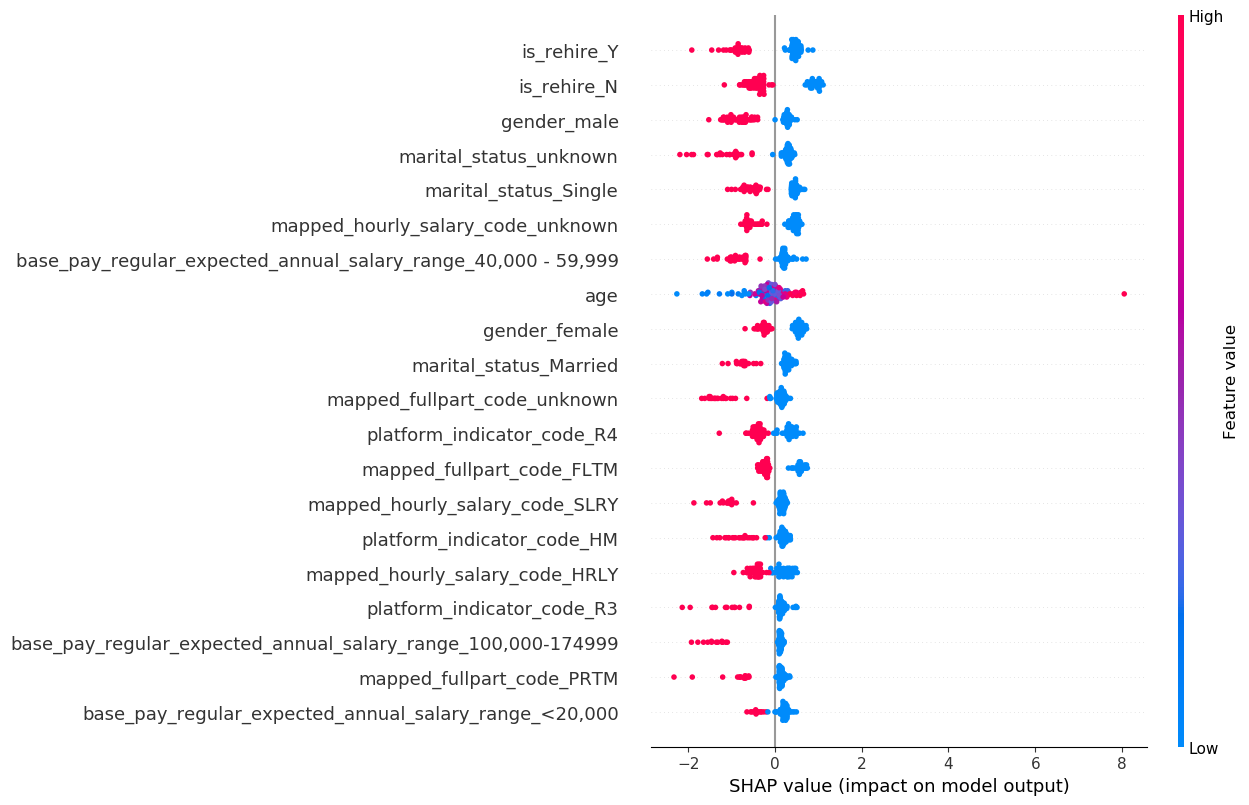

In [201]:
shap.summary_plot(shap_values)

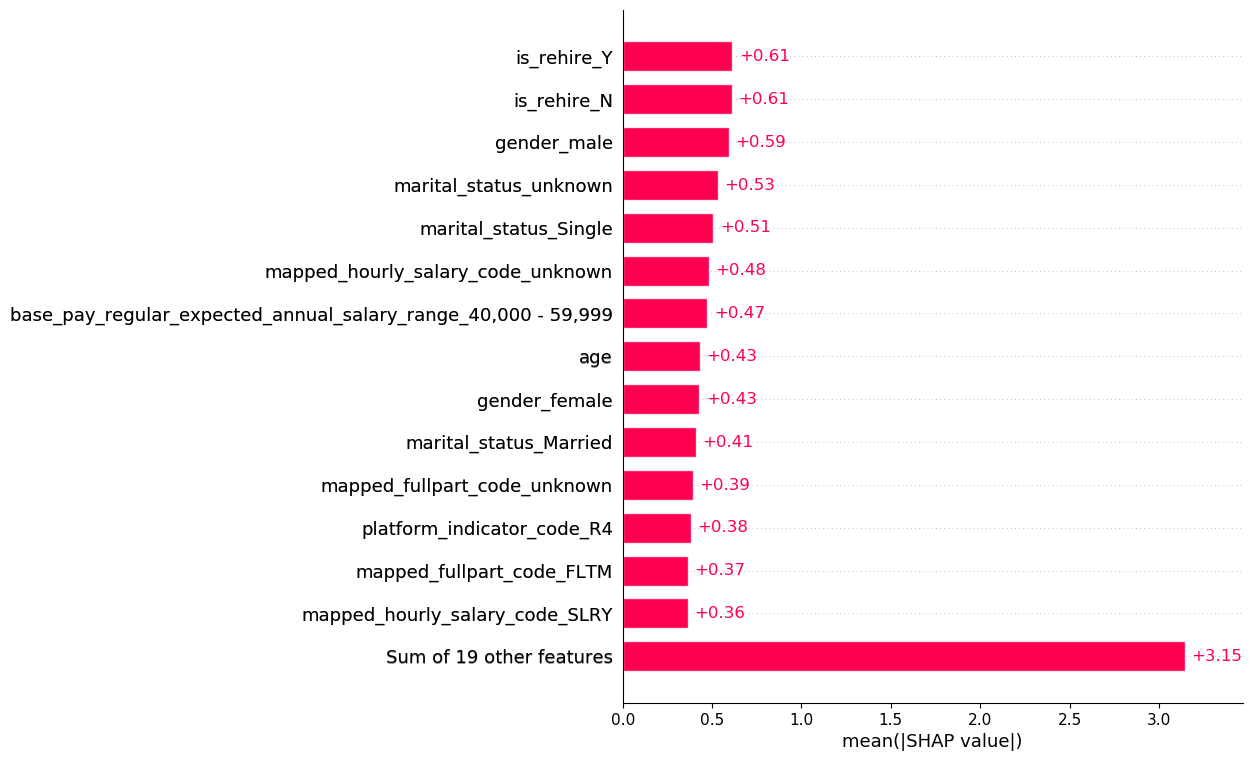

<Figure size 640x480 with 0 Axes>

In [202]:
shap.plots.bar(shap_values, max_display=15)
plt.savefig('shap.png')

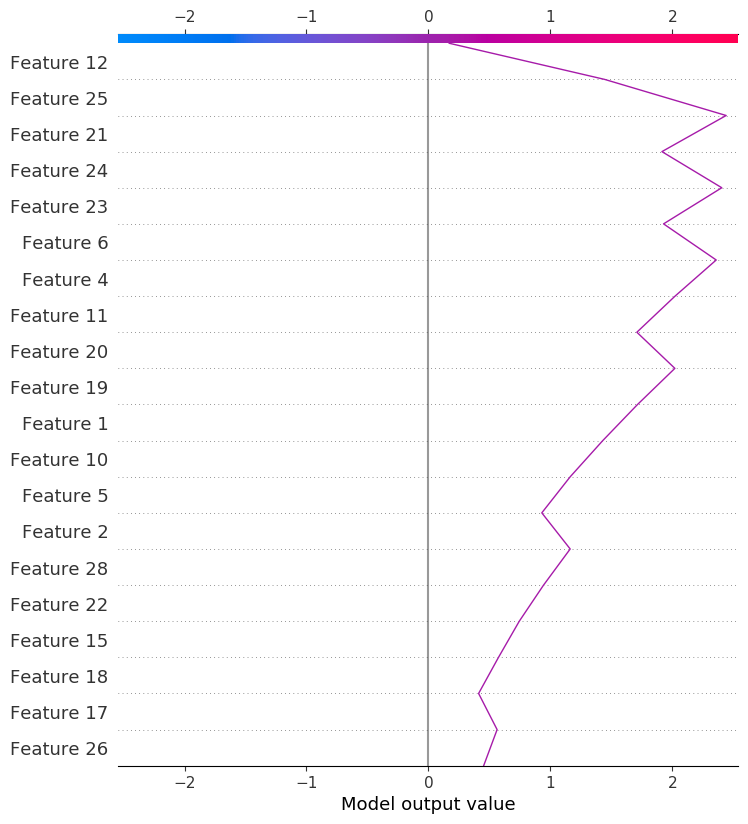

In [203]:
shap.decision_plot(shap_values.base_values[0], shap_values.values[0])

In [204]:
# sex = ["ER Contributing" if shap_values[i,"er_hsa_contribution_flag_new_1"].data == 1 else "ER not Contributing" for i in range(shap_values.shape[0])]
# shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

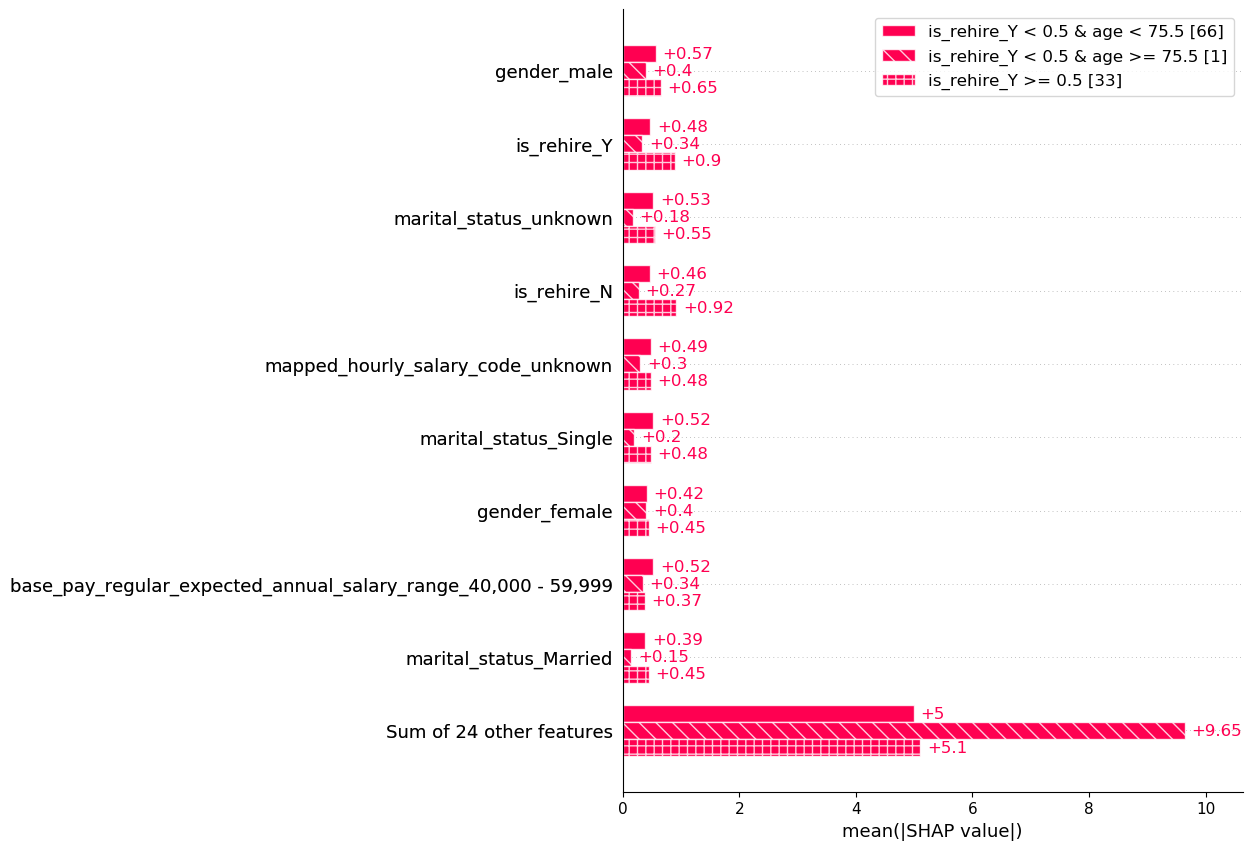

In [205]:
shap.plots.bar(shap_values.cohorts(3).abs.mean(0))

In [206]:
%%time
# Fits the explainer
explainer = shap.TreeExplainer(xgbc_best)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test[:100])

CPU times: user 39.5 s, sys: 137 ms, total: 39.6 s
Wall time: 14.2 s


In [207]:
pred_prob = xgbc_best.predict(X_test[:100])

In [208]:
pred_prob.mean()

0.42

In [209]:
shap_values.base_values

array([-0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00265413,
       -0.00265413, -0.00265413, -0.00265413, -0.00265413, -0.00

In [210]:
shap.initjs()
shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=X_test.columns)

In [211]:
shap.plots.force(shap_values.base_values[5],shap_values.values[0], feature_names=X_test.columns)

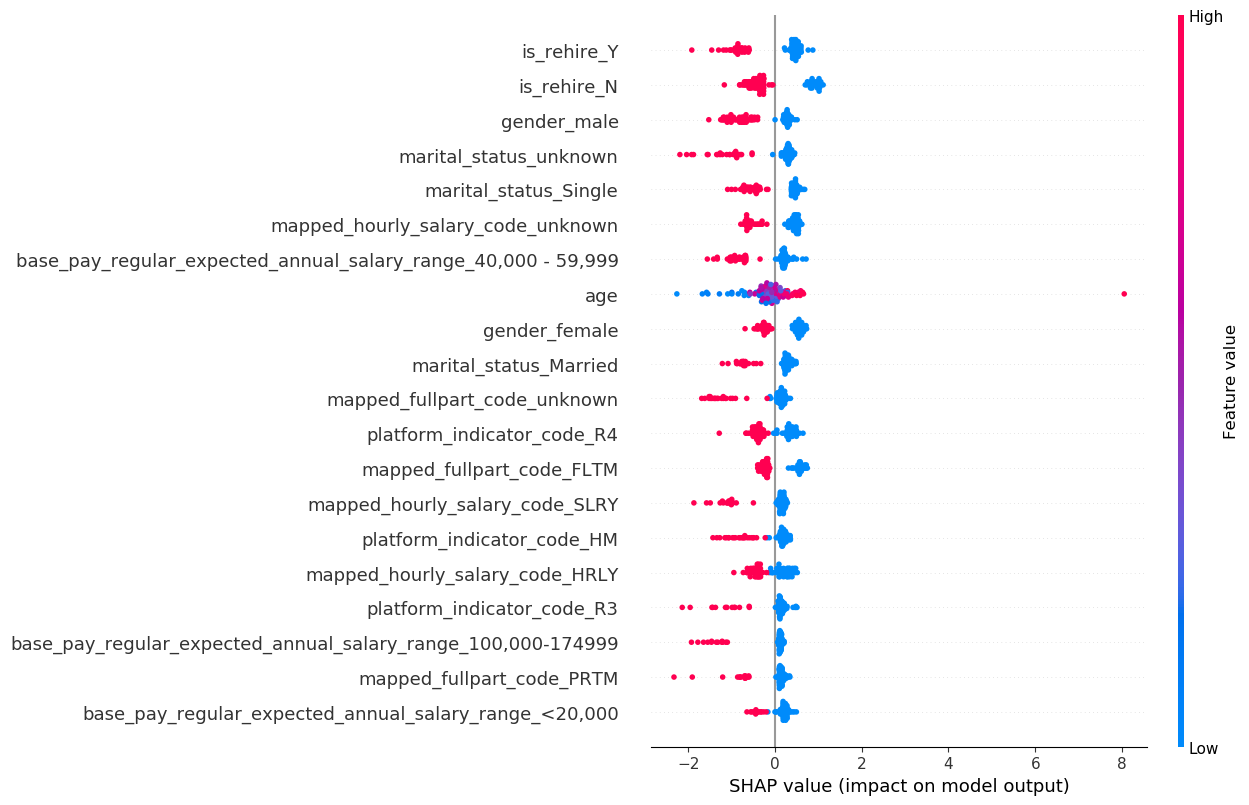

In [212]:
shap.summary_plot(shap_values)

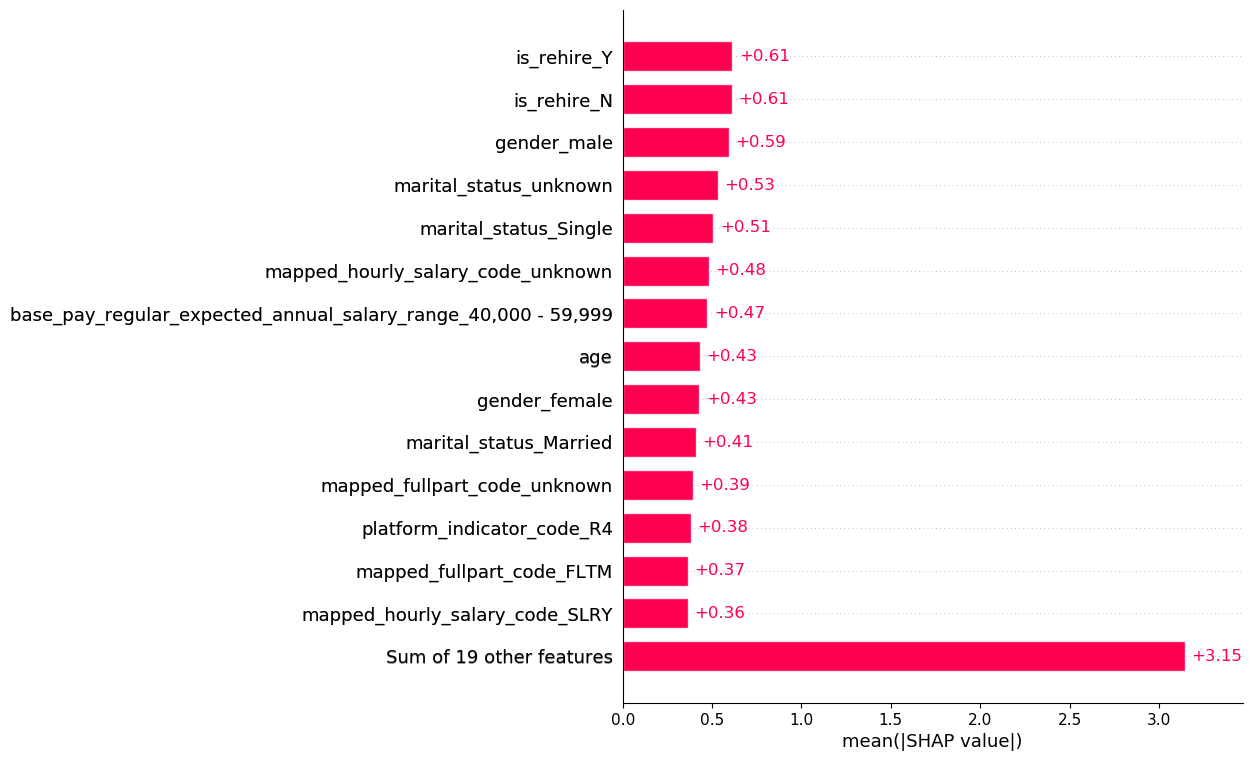

<Figure size 640x480 with 0 Axes>

In [213]:
shap.plots.bar(shap_values, max_display=15)
plt.savefig('shap.png')

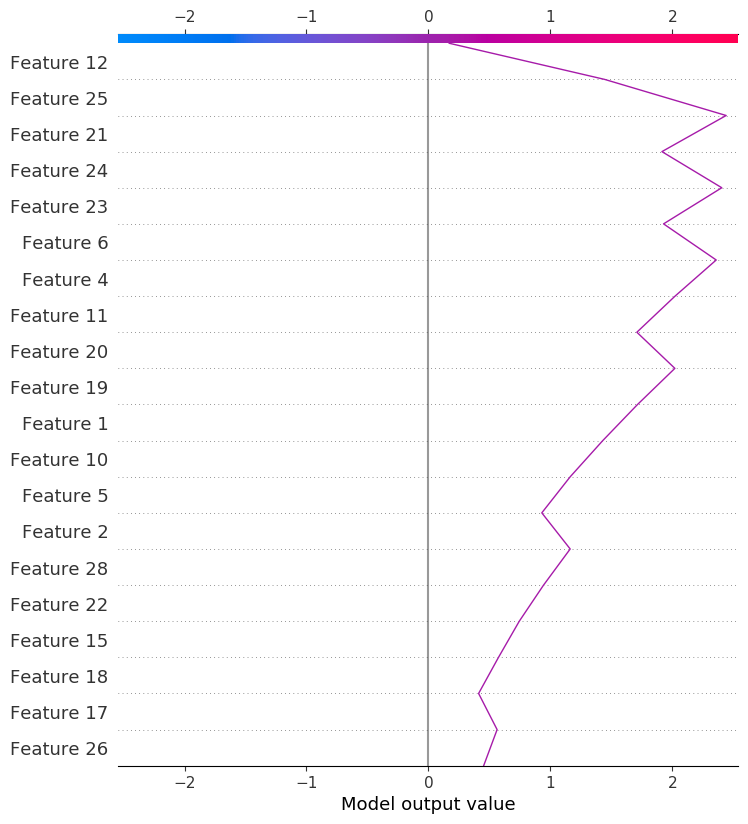

In [214]:
shap.decision_plot(shap_values.base_values[0], shap_values.values[0])

In [215]:
# Fits the explainer
explainer = shap.Explainer(xgbc_best.predict_proba, X_test[:2000])
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test[:2000])

Permutation explainer: 2001it [03:08, 10.60it/s]                          


In [216]:
pred_prob = xgbc_best.predict_proba(X_test[:2000])

In [217]:
pred_prob[:, 1].mean()

0.39119852

In [218]:
shap_values.values[5,:,1]

array([-0.05220546, -0.18626986,  0.1265331 ,  0.        , -0.14619949,
        0.01853534,  0.03034159,  0.        ,  0.        ,  0.        ,
       -0.21215182,  0.17273427,  0.02582747,  0.        ,  0.        ,
        0.06215383,  0.00312275, -0.13053222,  0.06416856,  0.05816871,
       -0.0641076 ,  0.08545745,  0.01435734, -0.06516028,  0.12158333,
       -0.16820498,  0.02226764,  0.01761196, -0.00653521,  0.01742855,
        0.02016932,  0.        ,  0.        ])

In [219]:
# shap.initjs()
shap.plots.force(shap_values.base_values[5,1],shap_values.values[5,:,1], feature_names=X_test.columns)

In [220]:
shap.plots.force(shap_values.base_values[0,1],shap_values.values[0,:,1], feature_names=X_test.columns)

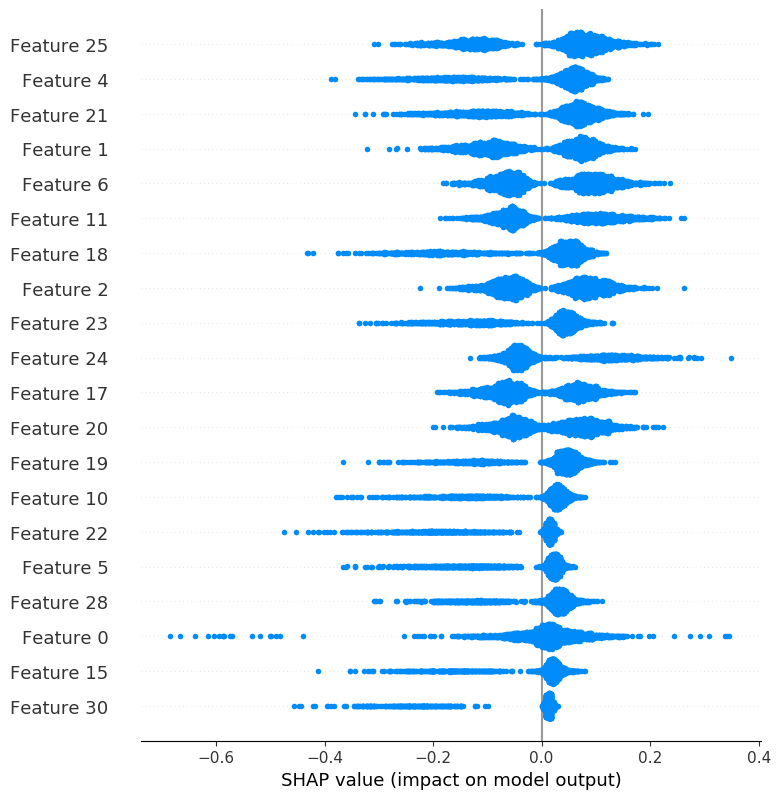

In [221]:
shap.summary_plot(shap_values.values[:,:,1])

In [222]:
shap_values.values[:,:,1][0]

array([ 0.00361793,  0.0838154 , -0.09228182,  0.        ,  0.06160915,
        0.01997812, -0.06481587,  0.        ,  0.        ,  0.        ,
        0.03182581,  0.1171522 , -0.26256593,  0.        ,  0.        ,
        0.02731122,  0.00802664, -0.0605629 ,  0.06146674,  0.0891732 ,
       -0.03279414,  0.11610797,  0.0175977 ,  0.05328451, -0.04985302,
       -0.09653721,  0.0156959 ,  0.02878337,  0.02631005,  0.01666589,
        0.00152703,  0.        ,  0.        ])